#Working sampling processing and predictive distributions
OJM

In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
from scipy import stats
import scipy.interpolate as interpolate
import scipy.special as special
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import errno
import george
from george import kernels
import statsmodels.api as sm

In [2]:
%matplotlib inline
#%matplotlib notebook
%config InlineBackend.close_figures = False #so inline mode doesn't auto close figures at end of cell

In [3]:
plt.close('all')

In [4]:
#want to change some gloabl plot font settings - save first. Make sure to only run once on clean set.
rc_default = plt.rcParams.copy()

In [5]:
rc_default

{'agg.path.chunksize': 0,
 'animation.avconv_args': '',
 'animation.avconv_path': 'avconv',
 'animation.bitrate': -1,
 'animation.codec': 'mpeg4',
 'animation.convert_args': '',
 'animation.convert_path': 'convert',
 'animation.ffmpeg_args': '',
 'animation.ffmpeg_path': 'ffmpeg',
 'animation.frame_format': 'png',
 'animation.mencoder_args': '',
 'animation.mencoder_path': 'mencoder',
 'animation.writer': 'ffmpeg',
 'axes.axisbelow': False,
 'axes.color_cycle': ['b', 'g', 'r', 'c', 'm', 'y', 'k'],
 'axes.edgecolor': 'k',
 'axes.facecolor': 'w',
 'axes.formatter.limits': [-7, 7],
 'axes.formatter.use_locale': False,
 'axes.formatter.use_mathtext': False,
 'axes.grid': False,
 'axes.hold': True,
 'axes.labelcolor': 'k',
 'axes.labelsize': 'medium',
 'axes.labelweight': 'normal',
 'axes.linewidth': 1.0,
 'axes.titlesize': 'large',
 'axes.unicode_minus': True,
 'axes.xmargin': 0,
 'axes.ymargin': 0,
 'axes3d.grid': True,
 'backend': 'module://ipykernel.pylab.backend_inline',
 'backend.qt4'

In [6]:
#can access particular entries.
plt.rcParams['axes.labelsize']

'medium'

In [7]:
# re-setting
plt.rcParams.update(rc_default)

## Processing of posterior chains

In [8]:
#fixed/initial parameters
#make sure same as what sim was run with. Need some kind of config file?
p0= np.array([0.5,1.5,0.5,0.0,0.0])#decent guess at solution, based on opt.
#p0= np.array([1.0,1.5,0.5,0.0,0.0])#decent guess at solution, based on opt.
#p0= np.array([0.1,0.1,0.1,0.0,0.0])#decent guess at solution, based on opt.
p_var_i= [0,1,2,3,4]
p0= np.append(p0,np.zeros(15))

print 'num free parameters'
print len(p_var_i)
print 'num fixed parameters'
print len(p0)-len(p_var_i)

num free parameters
5
num fixed parameters
15


In [9]:
#get sampler back
import emcee
import pickle

#-Main sample of interest
sample_type= 'AraC'
#load_path= '../raw-output/AraC/'
#load_path= '../raw-output/AraC_1140_1500/'
#load_path= '../raw-output/AraC_1620_2520/'
load_path= '../raw-output/AraC_2100_2520/'

##load_path= '../raw-output/AraC_1080_1260_1500/'

#sample_type= 'BrdU'
#load_path='../raw-output/BrdU/'

#load_path= load_path_base+sample_type+'/'
file_name= 'sampler_flat_chain_'+sample_type+'.p'
#p_var_i= [0,1,2,3]

sampler_flat_chain = pickle.load( open( load_path+file_name, "rb" ) )

#-Control sample
sample_type_control= 'BrdU'
load_path= '../raw-output/BrdU/'

file_name= 'sampler_flat_chain_'+sample_type_control+'.p'
#p_var_i= [0,1,2,3]

sampler_flat_chain_control = pickle.load( open( load_path+file_name, "rb" ) )

In [10]:
print sampler_flat_chain.shape #5000, 5
print sampler_flat_chain_control.shape

(5000, 5)
(5000, 5)


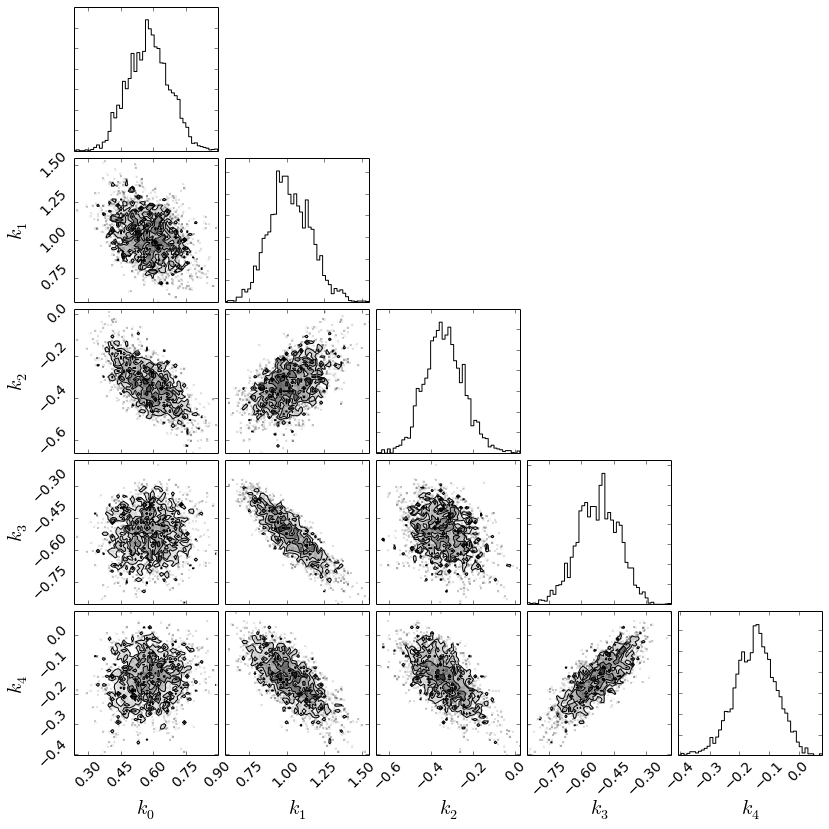

In [11]:
import triangle
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 20
tri_plot= triangle.corner(sampler_flat_chain, labels=['$k_'+str(p_var_i[i])+'$' for i in range(0,len(p_var_i))])
plt.rcParams.update(rc_default)
#plt.xlabel('xlabel', fontsize=18)
#tri_plot.get_axes().ylabel('time (min)')
#ax= tri_plot.get_axes()
#ax[5].fontsize=20

In [12]:
#plt.rcParams.update(rc_default)

In [13]:
#sample_type= 'AraC'
#sample_type= 'BrdU'
output_path= '../figures/proliferation_profiles/'
save_path= output_path+sample_type+'/'
save_fig= True
if save_fig:
    try:
        os.makedirs(save_path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(save_path):
            pass
        else: raise
    tri_plot.savefig(save_path+'mcmc-proliferation-rates-processed-'+sample_type+'.pdf')
tri_plot.show()

/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:371: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


##Parameter samples

In [14]:
n_param_samples=20

##Prior parameter samples
Notes:  
Need code for generating *samples* from prior, not density.

In [15]:
def sample_prior(prior_type,num_prior_samples,sigma,p_var_i,p0):
    if prior_type=='uniform':
        return np.random.uniform(low=-sigma,high=sigma,size=(num_prior_samples,len(p_var_i)))
    if prior_type=='gaussian':
        return np.random.multivariate_normal(p0[p_var_i], sigma, num_prior_samples)

In [16]:
num_prior_samples= n_param_samples
#sigma_prior=1.0# typical variation in rates. Note: should make e.g. decay? Uncertainty decreases?

#prior_type= 'uniform'
#sigma= 1.0

prior_type= 'gaussian'

parameter_correlation_length= 2.0
#parameter_correlation_length= 5.0 #long

kernel = kernels.ExpSquaredKernel(0.5*parameter_correlation_length) #0.5 -> correlation length approx. 1 parameter; lp=2*L->L=0.5*lp.
gp = george.GP(kernel)
#sigma_prior=1./np.exp(p_var_i)# typical variation in rates. Note: should make e.g. decay? Uncertainty decreases?
#sigma_prior= 1.0
#sigma= sigma_prior*gp.get_matrix(p_var_i)
#sigma[-1,-1]= np.exp(-1)*sigma[-1,-1]
#print sigma
#print sigma_prior

correlation_matrix= gp.get_matrix(p_var_i)
sd_decay_region=3
print '-'
print correlation_matrix[0,1:1+sd_decay_region]
print '-'
sd_prior= 1.0*np.append(np.ones(len(p_var_i)-sd_decay_region),correlation_matrix[0,1:1+sd_decay_region]) #correlation_matrix[0,:]#
#sd_prior= 0.5*np.append(np.ones(len(p_var_i)-sd_decay_region),correlation_matrix[0,1:1+sd_decay_region]) #correlation_matrix[0,:]#
print sd_prior
print '-'
var_prior= np.outer(sd_prior,sd_prior)
sigma= var_prior*correlation_matrix #note: element-wise product
print var_prior
print '-'
print correlation_matrix
print '-'
print sigma

-
[ 0.60653066  0.13533528  0.011109  ]
-
[ 1.          1.          0.60653066  0.13533528  0.011109  ]
-
[[  1.00000000e+00   1.00000000e+00   6.06530660e-01   1.35335283e-01
    1.11089965e-02]
 [  1.00000000e+00   1.00000000e+00   6.06530660e-01   1.35335283e-01
    1.11089965e-02]
 [  6.06530660e-01   6.06530660e-01   3.67879441e-01   8.20849986e-02
    6.73794700e-03]
 [  1.35335283e-01   1.35335283e-01   8.20849986e-02   1.83156389e-02
    1.50343919e-03]
 [  1.11089965e-02   1.11089965e-02   6.73794700e-03   1.50343919e-03
    1.23409804e-04]]
-
[[  1.00000000e+00   6.06530660e-01   1.35335283e-01   1.11089965e-02
    3.35462628e-04]
 [  6.06530660e-01   1.00000000e+00   6.06530660e-01   1.35335283e-01
    1.11089965e-02]
 [  1.35335283e-01   6.06530660e-01   1.00000000e+00   6.06530660e-01
    1.35335283e-01]
 [  1.11089965e-02   1.35335283e-01   6.06530660e-01   1.00000000e+00
    6.06530660e-01]
 [  3.35462628e-04   1.11089965e-02   1.35335283e-01   6.06530660e-01
    1.00000

In [17]:
#prior_samples= np.random.uniform(low=-sigma_prior,high=sigma_prior,size=(num_prior_samples,len(p_var_i)))
prior_samples= sample_prior(prior_type,num_prior_samples,sigma,p_var_i,p0)

In [18]:
plt.close('all')

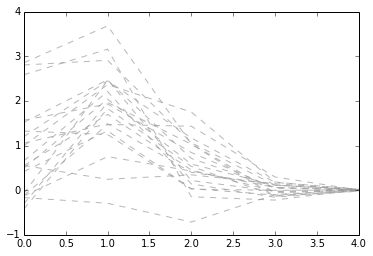

In [19]:
plt.plot(prior_samples.T,linestyle='--',color='0.6',alpha=0.7)
plt.show()
#plt.plot(prior_samples.T,linestyle='-',color='0.0',alpha=1.0)

## Posterior parameter samples

In [20]:
# Uses sampler chain from above
n_posterior_samples= n_param_samples
posterior_samples= sampler_flat_chain[np.random.randint(len(sampler_flat_chain), size=n_posterior_samples)]
for sample in posterior_samples:
    print sample
    #pl.plot(x, model1(s, x), color="#4682b4", alpha=0.3)

[ 0.63768247  1.12624672 -0.25027906 -0.58029767 -0.21366749]
[ 0.57107682  1.17751111 -0.33328559 -0.62439883 -0.17947317]
[ 0.68606699  1.07501349 -0.36079314 -0.57732935 -0.18122958]
[ 0.48542122  0.90050485 -0.30877077 -0.44155836 -0.13695915]
[ 0.53337352  1.0078528  -0.28554562 -0.57592335 -0.16701658]
[ 0.69799899  1.27864084 -0.25374074 -0.73536329 -0.31009061]
[ 0.71190058  0.9905667  -0.46526372 -0.56953597 -0.15070038]
[ 0.55509161  0.84317122 -0.35460744 -0.42100596 -0.08326626]
[ 0.5237268   1.0219765  -0.32495549 -0.50995047 -0.12586296]
[ 0.57324139  0.76714376 -0.3499736  -0.2947213  -0.00658632]
[ 0.64697444  1.26566099 -0.34987049 -0.73386434 -0.24456499]
[ 0.49832633  1.08899461 -0.29291089 -0.57473274 -0.1538592 ]
[ 0.57756207  1.00908786 -0.38216976 -0.49938869 -0.17391034]
[ 0.45134841  0.96098108 -0.23973966 -0.37431331 -0.11870637]
[ 0.57975024  0.79205387 -0.39806807 -0.37305351 -0.00730901]
[ 0.73086599  1.0721406  -0.37949955 -0.54470339 -0.13791255]
[ 0.5556

In [21]:
# Uses control sampler chain from above
n_posterior_samples_control= n_param_samples
posterior_samples_control= sampler_flat_chain_control[np.random.randint(len(sampler_flat_chain_control), size=n_posterior_samples_control)]
for sample in posterior_samples_control:
    print sample
    #pl.plot(x, model1(s, x), color="#4682b4", alpha=0.3)

[ 0.19099723  1.23316329  1.02401529  0.06454613 -0.01124537]
[ 0.24823184  1.21545042  0.97200298  0.31871697  0.00395191]
[  3.98618252e-01   9.77451294e-01   9.58835249e-01   2.42762691e-01
  -2.95444589e-04]
[ 0.33209416  0.96543632  1.02666525  0.20495828  0.0079903 ]
[ 0.22252955  1.28164504  0.89893615  0.14218021  0.00746161]
[ 0.33766402  1.08158206  0.98520058  0.22539776  0.00634313]
[ 0.27513209  1.16077012  0.93183482  0.29848819  0.01223998]
[  2.01347962e-01   1.37544604e+00   8.59928407e-01   1.17873452e-01
   8.52140032e-04]
[ 0.26890111  1.13716076  1.00794441  0.15440116  0.00965489]
[ 0.22344079  1.24033008  0.88479859  0.18801589  0.00215838]
[ 0.30413807  1.12583898  1.02239983  0.12745572  0.00424875]
[ 0.42000092  0.99559594  0.87171041  0.3872951   0.02362076]
[ 0.22113866  1.28695668  0.95210445  0.09786228  0.00729352]
[ 0.20358675  1.12331301  1.03277456  0.35673107  0.01088417]
[ 0.29019666  1.09854304  1.02048569  0.23045571  0.01971177]
[ 0.16691505  1.37

## Predictive simulations (either/or prior/posterior)
Note: found george (gaussian process package by emcee creator) example helpful. Compares with emcee.  
See http://dan.iel.fm/george/current/user/model/  
TODO 
- figure formatting...
- ensembles 
- prior sd decreasing

### For underlying predictor

In [22]:
%run simulation_functions.ipynb

In [23]:
plt.rcParams.update(rc_default)

In [24]:
#---figure settings and labels----
plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['axes.labelsize'] = 24
#plt.rcParams['axes.textsize'] = 24
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['figure.autolayout'] = 'True'
mpl.use("pgf")
plt.rcParams['font.family']='serif'
plt.rcParams['text.usetex'] = 'True'
plt.rcParams['font.serif']= ['Computer Modern Roman'] #along with pgf, uses latex default
#plt.rcParams['pgf.rcfonts'] = False
plt.rcParams['pgf.preamble']= ["\\usepackage{unicode-math}"]  # unicode math setupr
                             #r"\setmathfont{xits-math.otf}",
                             #r"\setmainfont{'Computer Modern Roman'}", # serif font via preamble
                             #]
#plt.rcParams['image.cmap'] = 'Greys'

/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


###predictive sims

In [25]:
#predictive simulations scale/type settings
x_min=0.
x_max= 100.
x= np.linspace(x_min,x_max,100)
x_plot_max= 50#46
x_text_loc_frac=0.6

#-data to use
#BrdU
##sample_type='BrdU'
#data_dir='../data-working/TXT_BrdU/'
#old_out_times= np.array([120.,360.,600.])#,600.,1080.])
#actual_out_times= np.array([120.,360.,600.,1080.])#,1080.])#,1440.,1920.,3360.])

##actual_out_times= np.array([1080.,1440.,1920.])#,3360.,4320.,4800.])

#AraC
##sample_type='AraC'
data_dir='../data-working/TXT_AraC_01_IdU/'
#old_out_times= np.array([1260.,1500.])#,1620.])
#old_out_times= np.array([1140.,1260.])#,1620.])
#old_out_times= np.array([1140.,1500.])#,1620.])
old_out_times= np.array([2100.,2520.])#,1620.])
#old_out_times= np.array([1620.,2520.])#,1620.])
#actual_out_times= np.array([1140.,1260.,1500.,1620.,2520.])#,2520.])
#actual_out_times= np.array([1620.,2520.])#,2520.])
actual_out_times = np.array([2100.,2520.])

##old_out_times= np.array([1080.,1260.,1500.])
##actual_out_times= np.array([1080.,1260.,1500.,1620.,2520.])
#actual_out_times= np.array([1080,1260.,1500.])

#Control
control_out_times= np.array([120.,360.,600.])

precision_time=4
time_format= '%0'+('%1d' % precision_time)+'d'
time_title_format = '%0'+('%1d' % 3)+'d'
#precision_time=4
#time_format= '%0'+('%1d' % precision_time)+'d'
k=3 #spline param
s=5 #spline param

time_scale_min_old= np.max(old_out_times)-np.min(old_out_times)
time_scale_min= np.max(actual_out_times)-np.min(actual_out_times)
time_scale_sec= time_scale_min/60.0
time_scale_renorm_ratio= time_scale_min_old/time_scale_min

time_scale_sec_control= (np.max(control_out_times)-np.min(control_out_times))/60.

print 'time scales - old, new, ratio; sec'
print time_scale_min_old
print time_scale_min
print time_scale_renorm_ratio
print time_scale_sec


time_scale_min= np.max(actual_out_times)-np.min(actual_out_times)
time_scale_sec= time_scale_min/60.0

print 'time scales'
print time_scale_min
print time_scale_sec

time scales - old, new, ratio; sec
420.0
420.0
1.0
7.0
time scales
420.0
7.0


In [26]:
#-which predictive distribution (prior or posterior)
dist_type= 'posterior'
paramter_samples= np.copy(posterior_samples)

#dist_type= 'prior'
#paramter_samples= np.copy(prior_samples)

#whether to plot control (e.g.healthy) as well. Use mainly for posterior AraC-treated.
add_control= True
#add_control= False

#re-scale parameter samples for different time predictions? 
paramter_samples= paramter_samples/time_scale_renorm_ratio

#-get ensembles
#proliferation_profile_ensemble
#velocity_profile_ensemble
#model_results_ensemble
#data_ensemble

num_fixed_params= len(p0)-len(p_var_i)

In [27]:
#reset if desired
plt.close('all')

/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "
/Users/user/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


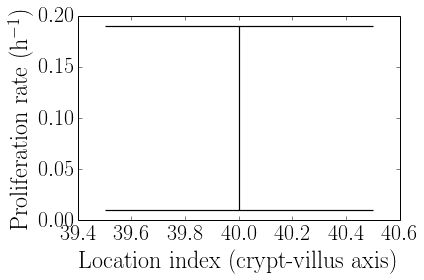

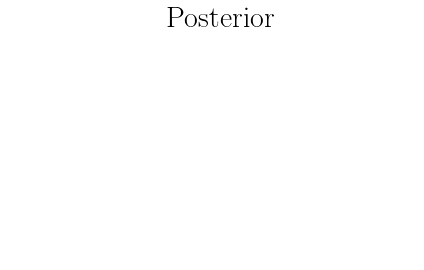

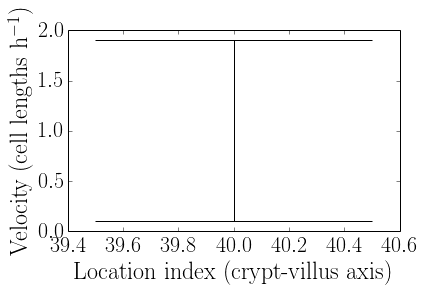

In [28]:
#--Create proliferation and velocity figures---
plt.figure("prolif-fig"+"-"+dist_type)
#if dist_type == 'prior':
#plt.axhline(y=-0.2,color='0.0',linestyle='-',linewidth=2.0,zorder=n_param_samples+1)


x_scale_bar = 0.8*x_plot_max
y_scale_bar_min = 0.01
y_scale_bar_max = 0.19
width_scale_bar = 0.01*x_plot_max
plt.vlines(x=x_scale_bar, ymin=y_scale_bar_min, ymax=y_scale_bar_max,color='0.0',linestyle='-',linewidth=1.2)
plt.hlines(y=[y_scale_bar_min,y_scale_bar_max], xmin=x_scale_bar-width_scale_bar, xmax=x_scale_bar+width_scale_bar,color='0.0',linestyle='-',linewidth=1.2)
#TODO REPLACE
#plt.axhline(y=0.0,color='0.0',linestyle='--',linewidth=1.2,zorder=n_param_samples+1)
#plt.axhline(y=0.18,color='0.0',linestyle='--',linewidth=1.2,zorder=n_param_samples+1)

#plt.xlim(0,x[-1])
#plt.ylim(-0.2,0.4)
plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 4) ) #change y-ticks
plt.xlabel('Location index (crypt-villus axis)')
plt.ylabel('Proliferation rate (h$^{-1}$)')
#plt.title('P'+dist_type[1:],y=1.2,size=30)
plt.legend()#(prop={'size':6})    

#create title stamp
plt.figure('P'+dist_type[1:]+'-stamp')
plt.axis('off')
plt.title('P'+dist_type[1:],y=1.2,size=30)

plt.figure("vel-fig"+"-"+dist_type,)
#if dist_type == 'prior':
#plt.axhline(y=-1.0,color='0.0',linestyle='-',linewidth=2.0,zorder=n_param_samples+1)

#change y scale
y_scale_bar_min = 0.1
y_scale_bar_max = 1.90
plt.vlines(x=x_scale_bar, ymin=y_scale_bar_min, ymax=y_scale_bar_max,color='0.0',linestyle='-',linewidth=1.0)
plt.hlines(y=[y_scale_bar_min,y_scale_bar_max], xmin=x_scale_bar-width_scale_bar, xmax=x_scale_bar+width_scale_bar,color='0.0',linestyle='-',linewidth=1.0)
#TODO REPLACE
#plt.axhline(y=0.0,color='0.0',linestyle='--',linewidth=1.2,zorder=n_param_samples+1)
##plt.axhline(y=1.0,color='0.0',linestyle='-',linewidth=2.0,zorder=n_param_samples+1)
#plt.axhline(y=1.98,color='0.0',linestyle='--',linewidth=1.2,zorder=n_param_samples+1)

#plt.xlim(0,x[-1])
#plt.ylim(-2,5)
plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 4) )
plt.xlabel(r'Location index (crypt-villus axis)')
plt.ylabel(r'Velocity (cell lengths h$^{-1}$)')
plt.legend()#(prop={'size':6})

AraC_01_2100min.txt
here
../data-working/TXT_AraC_01_IdU/AraC_01_2100min.txt
AraC_01_2100min.txt

/Users/user/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/user/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/user/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:50: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



here
../data-working/TXT_AraC_01_IdU/AraC_01_2100min.txt
AraC_01_2520min.txt
here
../data-working/TXT_AraC_01_IdU/AraC_01_2520min.txt
AraC_01_2520min.txt
here
../data-working/TXT_AraC_01_IdU/AraC_01_2520min.txt


/Users/user/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


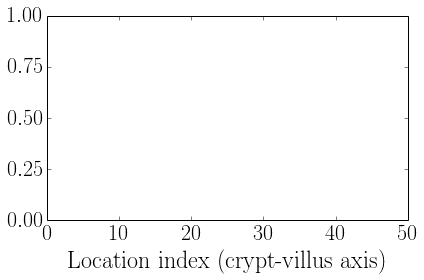

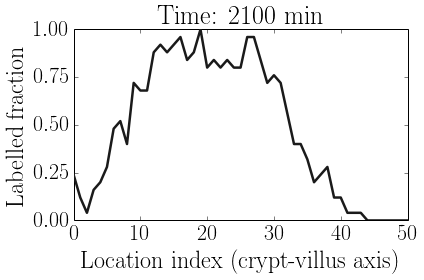

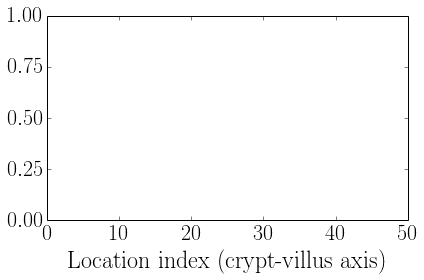

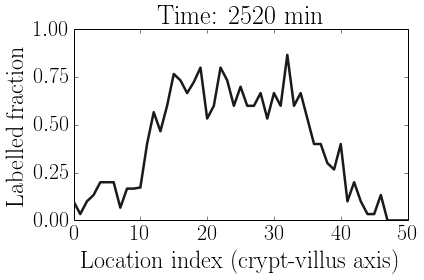

In [29]:
#---create main time-dependent figures (& plot data only)---
x_data_to_plot= np.tile(np.arange(x_min,x_max),(len(actual_out_times),1))
x_data_to_plot= np.transpose(x_data_to_plot)

label_data_at_x_data= np.zeros(x_data_to_plot.shape)
sample_size_at_x_data= np.zeros(x_data_to_plot.shape)
label_smoothed_data_at_x_data= np.zeros(x_data_to_plot.shape)

for i in range(0,len(actual_out_times)):
    #--for noise-free--
    #labels at each time
    plt.figure("label-fig-"+str(actual_out_times[i])+"-"+dist_type)
    plt.xlabel(r'Location index (crypt-villus axis)')
    plt.xlim(0,x_plot_max)
    plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 4) )
    #plt.text(x_plot_max*x_text_loc_frac,0.8,'time: '+str(actual_out_times[i])+' min',size=18)
    #plot
    current_time= actual_out_times[i]
    file_current= get_data_file(data_dir,time_format%current_time)
    print file_current
    data_result= process_and_fit_label_data_file(data_dir=data_dir,file_to_fit=file_current,sample_type=sample_type,k=k,s=s,x_max=100,do_plot=False)
    sample_size_result= get_sample_sizes_for_data_file(data_dir=data_dir,file_to_fit=file_current,sample_type=sample_type,k=k,s=s,x_max=100,do_plot=False)
    #careful here - data grid concept needs to be tidied up.
    label_data_at_x_data[:,i]= np.append(data_result[0],np.zeros(x_max-data_result[0].size))
    sample_size_at_x_data[:,i]= np.append(sample_size_result,np.zeros(x_max-sample_size_result.size))
    label_smoothed_data_at_x_data[:,i]= data_result[-1](x_data_to_plot[:,0])
    #print 'smoothed'
    #print label_smoothed_data_at_x_data
    #print x_data_to_plot[:,0]
    #print data_result[-1](x_data_to_plot[:,0])
    
    #plt.plot(label_data_at_x_data[:,i],label=time_format%current_time+' min'+'_raw mean',markersize=5,linewidth=2.5,linestyle='-',color="#EA1212",alpha=1.0,zorder=n_param_samples+1)
    
    #--for with-noise--
    #labels
    plt.figure("label-rep-fig-"+str(actual_out_times[i])+"-"+dist_type)
    plt.xlabel(r'Location index (crypt-villus axis)')
    plt.ylabel(r'Labelled fraction')
    plt.xlim(0,x_plot_max)
    plt.gca().yaxis.set_major_locator( MaxNLocator(nbins = 4) )#, prune = 'lower') 
    plt.title('Time: '+str(time_title_format%actual_out_times[i])+' min')#,size=18)
    #plt.text(x_plot_max*x_text_loc_frac,0.8,'time: '+str(actual_out_times[i])+' min',size=18)
    #plot
    current_time= actual_out_times[i]
    file_current= get_data_file(data_dir,time_format%current_time)
    print file_current
    data_result= process_and_fit_label_data_file(data_dir=data_dir,file_to_fit=file_current,sample_type=sample_type,k=k,s=s,x_max=100,do_plot=False)
    sample_size_result= get_sample_sizes_for_data_file(data_dir=data_dir,file_to_fit=file_current,sample_type=sample_type,k=k,s=s,x_max=100,do_plot=False)
    #careful here - data grid concept needs to be tidied up.
    label_data_at_x_data[:,i]= np.append(data_result[0],np.zeros(x_max-data_result[0].size))
    sample_size_at_x_data[:,i]= np.append(sample_size_result,np.zeros(x_max-sample_size_result.size))
    plt.plot(label_data_at_x_data[:,i],label=time_format%current_time+' min'+'_raw mean',markersize=5,linewidth=2.5,linestyle='-',color='0.1',alpha=1.0,zorder=n_param_samples+1)
    
    #--For cumulative
    #plt.figure("normed measurement residuals cumulative")
    #ecdf_model = sm.distributions.ECDF(l_data_model_resid_normed)
    #ecdf_data = sm.distributions.ECDF(l_data_smoothed_resid_normed)
    #plt.plot(ecdf_model.x,ecdf_model.y,color='0.6',alpha=0.7)
    #plt.plot(ecdf_data.x,ecdf_data.y,color='0.1',alpha=0.7)
    #plt.xlim(-5,5)

/Users/user/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/user/anaconda/lib/python2.7/site-packages/scipy/integrate/quadpack.py:295: UserWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg)


[ 0.63768247  1.12624672 -0.25027906 -0.58029767 -0.21366749]
p non-dim
[ 0.63768247  1.12624672 -0.25027906 -0.58029767 -0.21366749  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
num parameters: 20
p (per h)
[ 0.0910975   0.16089239 -0.03575415 -0.08289967 -0.03052393  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
here
../data-working/TXT_AraC_01_IdU/AraC_01_2100min.txt
2016-08-18 11:59:26,743 INFO CLAW: Solution 0 computed for time t=0.000000
2016-08-18 11:59:26,756 INFO CLAW: Solution 1 computed for time t=1.000000
time taken: 2.34230589867
[ 0.07229991  0.05585386  0.04769417  0.04858033  0.05393941  0.06298258
  0.07273154  0.07910939  0.08278607  0.08524708  0.08858439  0.08845257
  0.08963471  0.09063052  0.09124856  0.09094727  0.08973324  0.

/Users/user/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:71: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


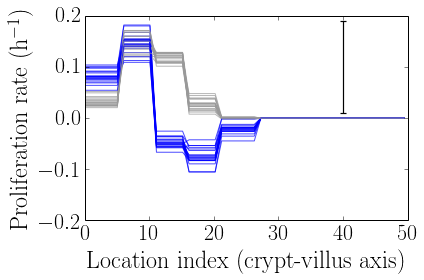

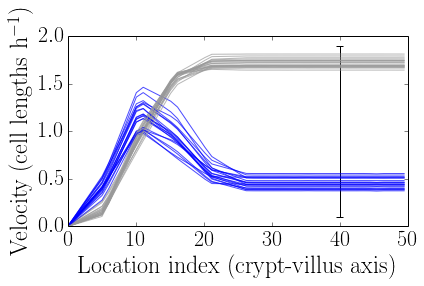

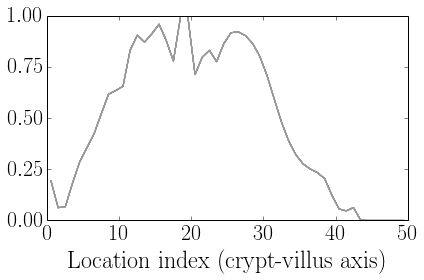

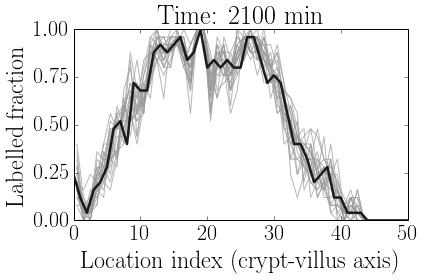

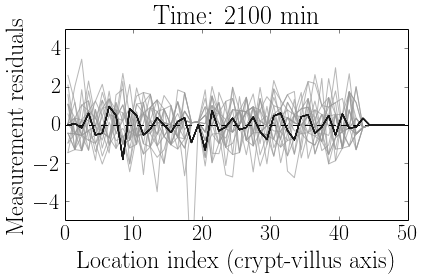

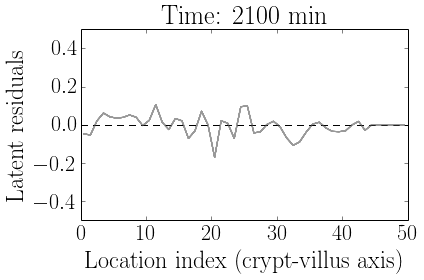

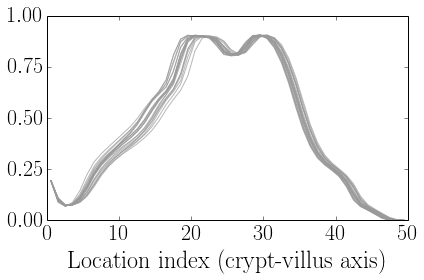

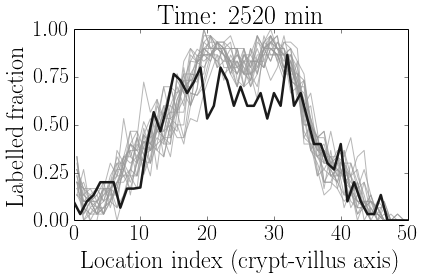

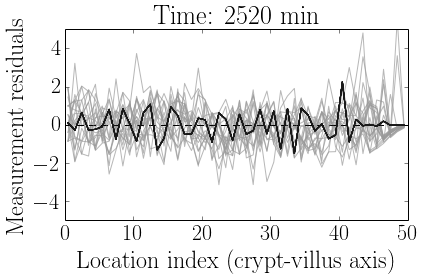

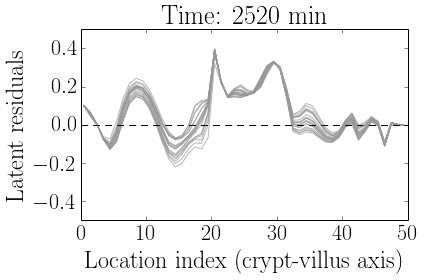

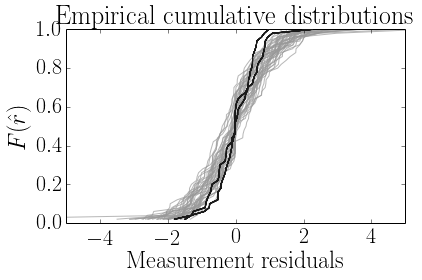

In [30]:
#--Add simulation realisations (for each parameter set)
#add_control = False
#add_control = True
#for sample in paramter_samples:
for i, sample in enumerate(paramter_samples):
    print sample
    p=sample
    p= np.append(p,np.zeros(num_fixed_params))
    print 'p non-dim'
    print p
    print 'num parameters: ' + str(p.size)
    p_dim = p/time_scale_sec
    print 'p (per h)'
    print p_dim
    
    if add_control:
        #treated (blue)
        plt.figure("prolif-fig"+"-"+dist_type)
        #plt.plot(x[0:x_plot_max],[proliferation_profile(p=p_dim,x_max=x_max)(x_i) for x_i in x[0:x_plot_max]],linestyle='-',color='0.6',alpha=0.7)
        plt.plot(x[0:x_plot_max],[proliferation_profile(p=p_dim,x_max=x_max)(x_i) for x_i in x[0:x_plot_max]],linestyle='-',color='b',alpha=0.7)
        
        k_prolif= proliferation_profile(p=p_dim,x_max=x_max)
        vel= [sp.integrate.quad(k_prolif,0,xs)[0] for xs in x]
        plt.figure("vel-fig"+"-"+dist_type)
        #plt.plot(x[0:x_plot_max],vel[0:x_plot_max],linestyle='-',color='0.6',alpha=0.7)
        plt.plot(x[0:x_plot_max],vel[0:x_plot_max],linestyle='-',color='b',alpha=0.7)
        
        #control
        p_control= posterior_samples_control[i]
        p_control= np.append(p_control,np.zeros(num_fixed_params))
        p_control_dim= p_control/time_scale_sec_control
        plt.figure("prolif-fig"+"-"+dist_type)
        #plt.plot(x[0:x_plot_max],[proliferation_profile(p=p_control_dim,x_max=x_max)(x_i) for x_i in x[0:x_plot_max]],linestyle='-',color='b',alpha=0.7)
        plt.plot(x[0:x_plot_max],[proliferation_profile(p=p_control_dim,x_max=x_max)(x_i) for x_i in x[0:x_plot_max]],linestyle='-',color='0.6',alpha=0.7)
        
        #plt.plot(np.mean(posterior_samples_control),color='0.0',linestyle='--',linewidth=2.0,zorder=n_param_samples+1)
        k_prolif_control= proliferation_profile(p=p_control_dim,x_max=x_max)
        vel_control= [sp.integrate.quad(k_prolif_control,0,xs)[0] for xs in x]
        plt.figure("vel-fig"+"-"+dist_type)
        #plt.plot(x[0:x_plot_max],vel_control[0:x_plot_max],linestyle='-',color='b',alpha=0.7)
        plt.plot(x[0:x_plot_max],vel_control[0:x_plot_max],linestyle='-',color='0.6',alpha=0.7)
    else:
        plt.figure("prolif-fig"+"-"+dist_type)
        plt.plot(x[0:x_plot_max],[proliferation_profile(p=p_dim,x_max=x_max)(x_i) for x_i in x[0:x_plot_max]],linestyle='-',color='0.6',alpha=0.7)
    
        k_prolif= proliferation_profile(p=p_dim,x_max=x_max)
        vel= [sp.integrate.quad(k_prolif,0,xs)[0] for xs in x]
        plt.figure("vel-fig"+"-"+dist_type)
        plt.plot(x[0:x_plot_max],vel[0:x_plot_max],linestyle='-',color='0.6',alpha=0.7)
    #plt.show()
    #plt.show()

    #--run model and plot [CHECK: is data being plotted over and over?]--
    import time as timer
    t0 = timer.time()
    results= construct_and_run_sim(data_dir=data_dir,sample_type=sample_type,actual_out_times=actual_out_times,precision_time=4,p=p,x_min=0.,x_max=x_max,nx=100)
    l_model= results[0]
    x_model= results[2]
    tf = timer.time()
    print 'time taken: '+ np.str(tf-t0)
    #--plot for each time
    for i in range(0,len(actual_out_times)):
        #-underlying model (& data?)
        plt.figure("label-fig-"+str(actual_out_times[i])+"-"+dist_type)
        plt.plot(x_model[0:x_plot_max,i],l_model[0:x_plot_max,i],linestyle='-',color='0.6',alpha=0.7)
        #EXTRA HERE TODO?
        #plt.plot(label_data_at_x_data[:,i],label=time_format%current_time+' min'+'_raw mean',markersize=5,linewidth=1.0,linestyle='-',color='0.1',alpha=0.7,zorder=n_param_samples+1)
        #-replications (noisy) for each underlying
        #-labels (& data?)
        reps_per_param= 1.0 #should be one?
        y_rep= np.random.binomial(sample_size_at_x_data[:,i].astype(int),l_model[:,i],size=[reps_per_param,len(l_model[:,i])])
        l_rep= np.divide(y_rep[:,0:x_plot_max],sample_size_at_x_data[0:x_plot_max,i])
        plt.figure("label-rep-fig-"+str(actual_out_times[i])+"-"+dist_type)
        plt.plot(x_model[0:x_plot_max,i],l_rep.T,linestyle='-',color='0.6',alpha=0.7)
        #EXTRA HERE TODO?
        #plt.plot(label_data_at_x_data[:,i],label=time_format%current_time+' min'+'_raw mean',markersize=5,linewidth=1.0,linestyle='-',color='0.1',alpha=0.7,zorder=n_param_samples+1) #"#EA1212"
        #-measurement residuals, model and data. Note - note note well-defined for discrete data??
        l_rep_data_resid= l_rep-label_data_at_x_data[0:x_plot_max,i] #model rep minus data mean resid.
        l_rep_model_resid= l_rep-l_model[0:x_plot_max,i] #model rep minus model mean resid.
        l_data_model_resid= label_data_at_x_data[0:x_plot_max,i]-l_model[0:x_plot_max,i] #data minus model mean resid.
        l_data_smoothed_resid= label_data_at_x_data[0:x_plot_max,i]-label_smoothed_data_at_x_data[0:x_plot_max,i]
        #-mean residuals
        l_model_data_latent_resid= l_model[0:x_plot_max,i]-label_smoothed_data_at_x_data[0:x_plot_max,i] #data minus model mean resid.
        #-normalised residuals (TODO - model or data sd?)
        sd_model= np.sqrt(np.divide(l_model[0:x_plot_max,i]*(1.-l_model[0:x_plot_max,i]),sample_size_at_x_data[0:x_plot_max,i])) 
        sd_data= np.sqrt(np.divide(label_smoothed_data_at_x_data[0:x_plot_max,i]*(1.-label_smoothed_data_at_x_data[0:x_plot_max,i]),sample_size_at_x_data[0:x_plot_max,i])) 
        l_rep_model_resid_normed= np.divide(l_rep_model_resid,sd_model)
        l_data_model_resid_normed= np.divide(l_data_model_resid,sd_model)
        l_data_smoothed_resid_normed= np.divide(l_data_smoothed_resid,sd_data)
        if i == len(actual_out_times)-1:
            print sd_model
            print sd_data
            print l_data_smoothed_resid_normed
        
        #not really of interest. WHY??
        #plt.figure("label-rep-resid-fig-"+str(actual_out_times[i]))
        #plt.plot(x_model[0:x_plot_max,i],l_rep_data_resid.T,linestyle='-',color='0.6',alpha=0.7)
        #plt.axhline(y=0.0,color='0.0',linestyle='--',linewidth=0.5)
        
        #normed measurement residuals
        plt.figure("label-measurement-residuals-normed-fig-"+str(actual_out_times[i])+"-"+dist_type)
        plt.xlabel("Location index (crypt-villus axis)")
        plt.ylabel("Measurement residuals")
        plt.title('Time: '+str(time_title_format%actual_out_times[i])+' min')#,size=18))
        plt.ylim(-5,5)
        plt.plot(x_model[0:x_plot_max,i],l_rep_model_resid_normed.T,linestyle='-',color='0.6',alpha=0.7)
        #plt.plot(x_model[0:x_plot_max,i],l_data_model_resid_normed.T,markersize=5,linewidth=2.5,linestyle='-',color="#EA1212",alpha=1.0,zorder=n_param_samples+1)
        plt.plot(x_model[0:x_plot_max,i],l_data_smoothed_resid_normed.T,markersize=5,linewidth=1.0,linestyle='-',color='0.1',alpha=0.7,zorder=n_param_samples+1) #"#EA1212"
        plt.axhline(y=0.0,color='0.0',linestyle='--',linewidth=0.5)
        
        #latent model-data residuals
        plt.figure("label-latent-residuals-normed-fig-"+str(actual_out_times[i])+"-"+dist_type)
        plt.xlabel("Location index (crypt-villus axis)")
        plt.ylabel("Latent residuals")
        plt.ylim(-0.5,0.5)
        plt.title('Time: '+str(time_title_format%actual_out_times[i])+' min')#,size=18))
        #plt.ylim(-5,5)
        plt.plot(x_model[0:x_plot_max,i],l_model_data_latent_resid.T,linestyle='-',color='0.6',alpha=0.7)
        plt.axhline(y=0.0,color='0.0',linestyle='--',linewidth=0.5)
        
        #cumulative residuals for model/data??
        plt.figure("measurement residuals cumulative"+"-"+dist_type)
        plt.xlabel("Measurement residuals")
        plt.ylabel("$F(\hat{r})$")
        plt.title('Empirical cumulative distributions')#,size=18))
        #ecdf_model = sm.distributions.ECDF(l_data_model_resid_normed)
        #print l_data_model_resid_normed.shape
        #print l_rep_model_resid_normed[0,:].shape
        ecdf_model = sm.distributions.ECDF(l_rep_model_resid_normed[0,:])
        ecdf_data = sm.distributions.ECDF(l_data_smoothed_resid_normed)
        
        #print ecdf_model
        #print ecdf_data
        plt.plot(ecdf_model.x,ecdf_model.y,color='0.6',alpha=0.7)
        plt.plot(ecdf_data.x,ecdf_data.y,markersize=5,linewidth=1.0,linestyle='-',color='0.1',alpha=0.7,zorder=n_param_samples+1)
        plt.xlim(-5,5)
        
#plt.rcParams.update(rc_default)   

### Characteristic plane plots

In [43]:
%run extra_plotting_functions.ipynb

In [44]:
print sample
p=sample
p= np.append(p,np.zeros(num_fixed_params))
print 'p non-dim'
print p
print 'num parameters: ' + str(p.size)
print 'p (per h)'
p_dim = p/time_scale_sec
print p_dim
print 'p non-dim new scale'
p_re_norm = p*time_scale_renorm_ratio
print p_re_norm
print 'p (per h)'
print p_dim

#run and plot CHECK: p_dim or not? Not, right?
import time as timer
t0 = timer.time()
results= construct_and_run_sim(data_dir=data_dir,sample_type=sample_type,actual_out_times=actual_out_times,precision_time=4,p=p,x_min=0.,x_max=x_max,nx=100)
l_model= results[0]
x_model= results[2]
tf = timer.time()
#levels= np.linspace(0,0.9,22)

[ 0.97029307  1.82863462  1.75187828  0.51314043  0.02969823]
p non-dim
[ 0.97029307  1.82863462  1.75187828  0.51314043  0.02969823  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
num parameters: 20
p (per h)
[ 0.06064332  0.11428966  0.10949239  0.03207128  0.00185614  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
p non-dim new scale
[ 0.48514653  0.91431731  0.87593914  0.25657022  0.01484911  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
p (per h)
[ 0.06064332  0.11428966  0.10949239  0.03207128  0.00185614  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.   

In [73]:
plt.close('all')
plt.close('characteristics')

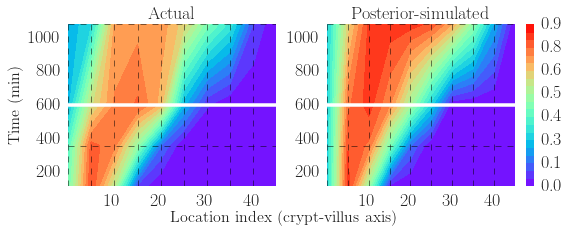

In [74]:
x_grid_step= 5
t_predict= 600.
levels= np.linspace(0,0.9,22)
import seaborn as sns
cmap = mpl.cm.rainbow

x_grid_all_times_model= x_model[0:x_plot_max,:]
label_data_at_x_data_model= l_model[0:x_plot_max,:]

#x_grid_all_times_data= x_model[0:x_plot_max,:]
label_data_at_x_data=label_smoothed_data_at_x_data[0:x_plot_max,:]

#X= x_data_to_plot[::2,0]
#Y= actual_out_times
#X, Y = np.meshgrid(X, Y)
#Z= label_smoothed_data_at_x_data[::2].T


X_model= x_grid_all_times_model[::x_grid_step,0]
Y= actual_out_times
Z_model= label_data_at_x_data_model[::x_grid_step].T
Z_data= label_data_at_x_data[::x_grid_step].T

#Z= label_data_at_x_data[::x_grid_step].T #assume given in column format


#from matplotlib import gridspec
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

plt.figure('characteristics')
#plt.xlabel("Location index (crypt-villus axis)")
#fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')
#fig = plt.figure(figsize=(8, 6)) 
#gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
#ax = plt.subplot2grid((1,4), (0,0), colspan=2)
#ax0 = plt.subplot(gs[0])
#ax0.plot(x, y)
#ax1 = plt.subplot(gs[1])
#ax1.plot(y, x)

#plt.tight_layout(rect=[0, 100, 300, 300])
#ax = plt.subplot(1,2,1)
#ax = plt.subplot(gs[0])
ax = plt.subplot2grid((2,21), (0,0), colspan=10)

#plt.contourf(X,Y,Z,levels=levels,cmap=cmap,shade=True)
#plt.imshow(X,Y,Z,interpolation='nearest')
plt.title('Actual',fontsize=18)

#plt.xlabel("Location index (crypt-villus axis)")
plt.ylabel("Time (min)",fontsize=16)

#plt.title('Time: '+str(time_title_format%actual_out_times[i])+' min')#,size=18))
#plt.xlabel('crypt-villus axis position (cell number)')
#plt.ylabel('time (min)')
#rep_num= rep_num+1

#plt.figure("replication"+str(rep_num))

plt.contourf(X_model,Y,Z_data,levels=levels,cmap=cmap,shade=True)
for x_loc in X_model:
    plt.axvline(x=x_loc,color='0.0',linestyle='--',linewidth=0.5)
    #print ''
for t_loc in Y:
    if t_loc == t_predict:
        plt.axhline(y=t_loc,color='1.0',linestyle='-',linewidth=3.5)
    else:
        plt.axhline(y=t_loc,color='0.0',linestyle='--',linewidth=0.5)
    #print ''
#plt.colorbar()
#plt.legend()

#plt.contourf(X,Y,Z,levels=levels,cmap=cmap,shade=True)
#for t_loc in actual_out_times:
#        plt.axhline(y=t_loc,color='0.0',linestyle='--',linewidth=0.5)
#        #print ''
#for x_loc in X:
#    plt.axvline(x=x_loc,color='0.0',linestyle='--',linewidth=0.5)
#plt.xlim(0,x_plot_max)

#ax = plt.subplot(gs[1])
#ax = plt.subplot(1,2,2)
ax = plt.subplot2grid((2,21), (0,10), colspan=11)
plt.contourf(X_model,Y,Z_model,levels=levels,cmap=cmap,shade=True)
for x_loc in X_model:
    plt.axvline(x=x_loc,color='0.0',linestyle='--',linewidth=0.5)
    #print ''
for t_loc in Y:
    if t_loc == t_predict:
        plt.axhline(y=t_loc,color='1.0',linestyle='-',linewidth=3.5)
    else:
        plt.axhline(y=t_loc,color='0.0',linestyle='--',linewidth=0.5)
plt.title('Posterior-simulated',fontsize=18)
#plt.xlim(0,x_plot_max)
#ax = plt.subplot2grid((2,5), (0,4), colspan=1)
#plt.contourf(X,Y,Z,levels=levels,cmap=cmap,shade=True)
#plt.contourf(X,Y,Z,levels=levels,cmap=cmap,shade=True)
#plt.subplot2grid((2,5), (0,4), colspan=1).axis('off')
plt.colorbar(format='%1.1f')#time_title_format = '%0'+('%1d' % 3)+'d')
plt.legend()
plt.figure('characteristics').text(0.5, 0.43, 'Location index (crypt-villus axis)', ha='center',size=16)
#plt.tight_layout()
#contours_out= plot_contours(label_data_at_x_data=label_smoothed_data_at_x_data[0:x_plot_max,:],x_grid_all_times=x_model[0:x_plot_max,:],actual_times=actual_out_times,levels=levels,data_type='estimated actual latent label',output_path='../figures/predictive_plots/',cmap=cmap,x_grid_step=x_grid_step,run_data_functions=False)

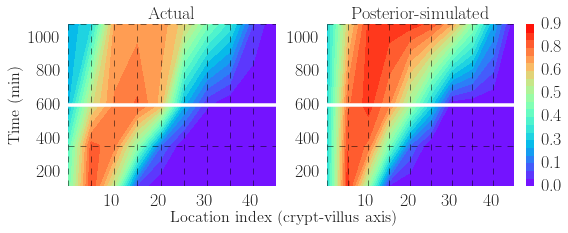

In [75]:
#test whether figures are closed (depends on %config InlineBackend.close_figures = False or not)
plt.figure("prolif-fig"+"-"+dist_type).show()
plt.figure("label-fig-"+str(actual_out_times[1])+"-"+dist_type).show()
plt.figure("label-rep-fig-"+str(actual_out_times[1])+"-"+dist_type).show()
plt.figure('characteristics').show()
#plt.show()

../figures/predictive_plots/BrdU/posterior-characteristics-BrdU.pdf


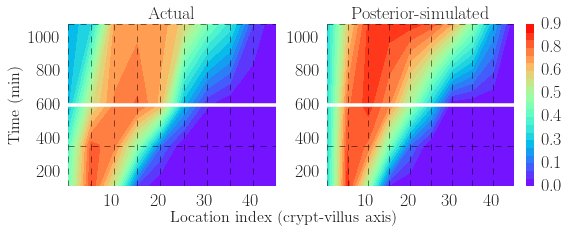

In [76]:
#plt.figure('characteristics').savefig(save_path+dist_type+'-characteristics-'+sample_type+'.pdf')
output_path='../figures/predictive_plots/'
save_path= output_path+sample_type+'/'
print save_path+dist_type+'-characteristics-'+sample_type+'.pdf'
plt.figure('characteristics').savefig(save_path+dist_type+'-characteristics-'+sample_type+'.pdf')

In [31]:
save_path+dist_type+'-multi-'+sample_type+'.pdf'

'../figures/proliferation_profiles/AraC/posterior-multi-AraC.pdf'

In [32]:
#doesn't work
#import figures2subplots
#figures2subplots = reload(figures2subplots)
#tfig = figures2subplots.multisubplot([plt.figure("vel-fig-"+dist_type),plt.figure("prolif-fig-"+dist_type)])
##plt.figure("prolif-fig-"+dist_type).show()
#tfig.show()

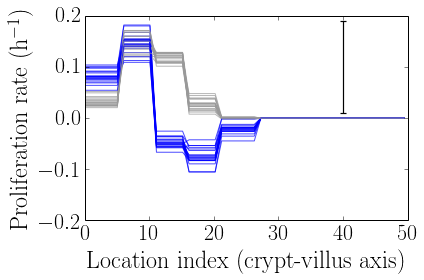

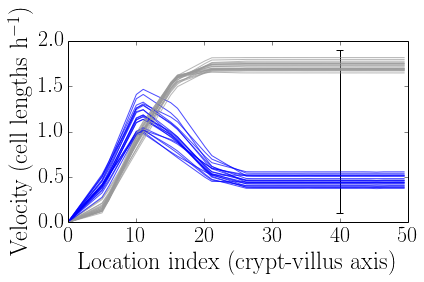

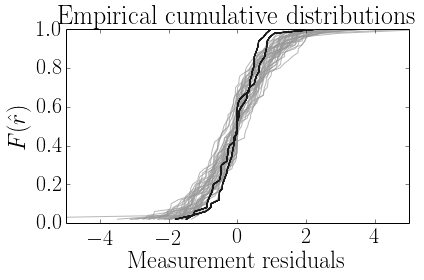

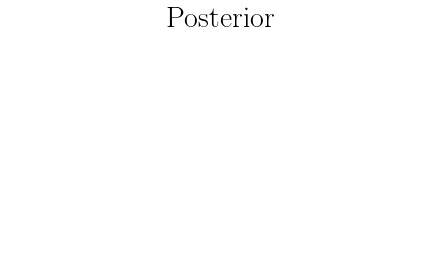

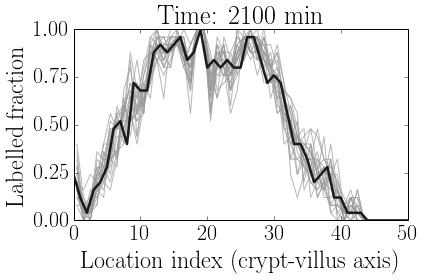

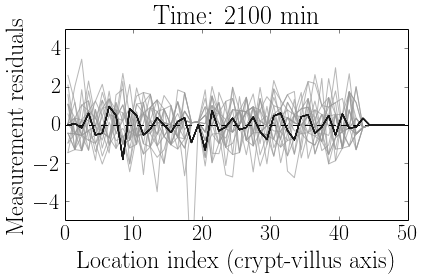

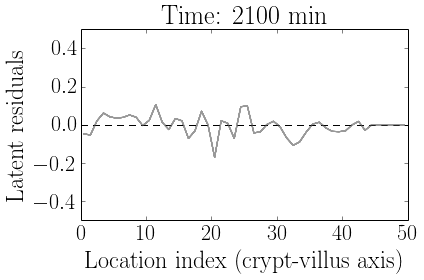

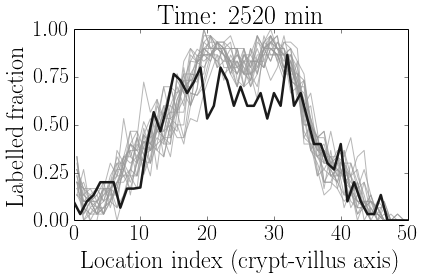

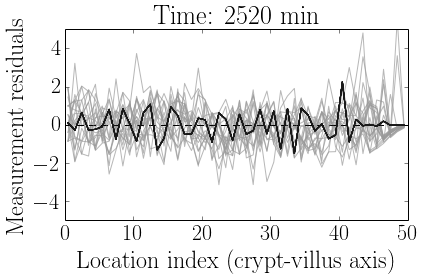

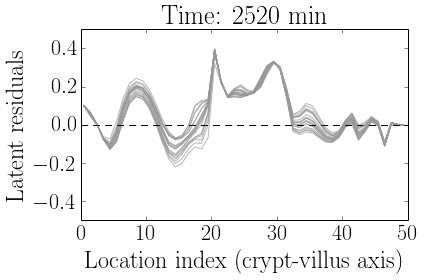

In [33]:
#save figures
save_figs= 'True'
if save_figs == 'True':
    #save figure
    output_path='../figures/predictive_plots/'
    save_path= output_path+sample_type+'/'
    try:
        os.makedirs(save_path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(save_path):
            pass
        else: raise
        plt.figure("prolif-fig"+"-"+dist_type).savefig(save_path+dist_type+'-proliferation-realisations-'+sample_type+'.pdf')
        plt.figure("vel-fig"+"-"+dist_type).savefig(save_path+dist_type+'-velocity-realisations-'+sample_type+'.pdf')
        plt.figure("measurement residuals cumulative"+"-"+dist_type).savefig(save_path+dist_type+'-empirical-cumulative-distributions-'+sample_type+'.pdf')
        plt.figure('P'+dist_type[1:]+'-stamp').savefig(save_path+dist_type+'-stamp-'+sample_type+'.pdf')
        plt.figure('characteristics').savefig(save_path+dist_type+'-characteristics-'+sample_type+'.pdf')
        #--each time figure
        for i in range(0,len(actual_out_times)):
            #plt.figure("label-fig-"+str(actual_out_times[i])).savefig(save_path+dist_type+'-proliferation-realisations-'+sample_type+'.pdf')
            plt.figure("label-rep-fig-"+str(actual_out_times[i])+"-"+dist_type).savefig(save_path+dist_type+'-label-realisations-'+sample_type+'-'+str(actual_out_times[i])+'-min'+'.pdf')
            #plt.figure("label-rep-resid-fig-"+str(actual_out_times[i])).savefig(save_path+dist_type+'-label-realisations-'+sample_type+'.pdf')
            plt.figure("label-measurement-residuals-normed-fig-"+str(actual_out_times[i])+"-"+dist_type).savefig(save_path+dist_type+'-label-measurement-residuals-normed-realisations-'+sample_type+'-'+str(actual_out_times[i])+'-min'+'.pdf')
            plt.figure("label-latent-residuals-normed-fig-"+str(actual_out_times[i])+"-"+dist_type).savefig(save_path+dist_type+'-latent-residuals-realisations-'+sample_type+'-'+str(actual_out_times[i])+'-min'+'.pdf')
        #plt.savefig

In [40]:
#close figures after saving
plt.close('all')

#check (should be empty)
plt.figure("prolif-fig"+"-"+dist_type).show()
plt.show()

### Layout of saved (pdf) figures via bash (imagemagick)
Note - need both prior and posterior available

In [41]:
%%bash
#copy directory structure
cd ../figures/predictive_plots/
#create temporary clone of dir structure, minus files
find . -type d >dirs.txt
cp dirs.txt ../working-layout/
cd ../working-layout/
xargs mkdir -p <dirs.txt

In [98]:
%%bash -s "$sample_type"
#prior and posterior proliferation and velocity plots
sample_type=$1

cd ../figures/predictive_plots/
#copy temporary files
cd $sample_type #sample_type
cp prior-posterior-stamp.pdf ../../working-layout/$sample_type/
cp prior-proliferation-realisations-$sample_type.pdf posterior-proliferation-realisations-$sample_type.pdf ../../working-layout/$sample_type/
cp prior-velocity-realisations-$sample_type.pdf posterior-velocity-realisations-$sample_type.pdf ../../working-layout/$sample_type/
#prior-label-realisations-$sample_type-120.0-min.pdf prior-label-realisations-$sample_type-360.0-min.pdf prior-label-realisations-$sample_type-600.0-min.pdf ../../working-layout/$sample_type/
#cp posterior-label-realisations-$sample_type-120.0-min.pdf posterior-label-realisations-$sample_type-360.0-min.pdf posterior-label-realisations-$sample_type-600.0-min.pdf ../../working-layout/$sample_type/
cd ../../working-layout/$sample_type/
#using pdfnup for arranging. See http://manpages.ubuntu.com/manpages/lucid/man1/pdfnup.1.html
#prior then posterior
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-prolif.pdf -dBATCH prior-proliferation*.pdf posterior-proliferation*.pdf
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH combined-prolif.pdf prior-velocity*.pdf posterior-velocity*.pdf
pdfnup combined.pdf --nup 2x2 --landscape --outfile prior-post-pro-vel.pdf
pdfcrop --margins '5 70 5 5' prior-post-pro-vel.pdf prior-post-pro-vel-cropped.pdf

#pdftk broken!
#add headings - part 1

gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=stamp-test.pdf -dBATCH stamp.pdf prior-post-pro-vel-cropped.pdf
pdfnup stamp-test.pdf --nup 2x1 --landscape --outfile stamp-test-side.pdf

pdfjam --keepinfo --landscape --trim "100mm 0mm 0mm 0mm" --clip true stamp-test-side.pdf -o test-side-cropped.pdf
pdfjam --keepinfo --landscape --trim "0mm 0mm 100mm 0mm" --clip true stamp-test-side.pdf -o stamp-side-cropped.pdf


#pdftk prior-posterior-stamp.pdf stamp prior-post-pro-vel-cropped.pdf output prior-post-pro-vel-cropped-stamped.pdf

#extra annotation
#extra_ann='-recovery-'

#cp prior-post-pro-vel-cropped-stamped.pdf ../../figures_to_include/$sample_type$extra_ann-prior-to-posterior-prolif-vel.pdf
#rm *.pdf #clean directory

GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 2.
Page 1
Page 2
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `prior-post-pro-vel-cropped.pdf'.
GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /Library/TeX/texbin/pdfjam --suffix nup --nup '2x1' --landscape --nup '2x2' --landscape --outfile prior-post-pro-vel.pdf -- combined.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'prior-post-pro-vel.pdf'.
   **** Warning: considering '0000000000 XXXXX n' as a free entry.
   **** Warning: considering '0000000000 XXXXX n' as a free entry.

   **** This file had errors that were repaired or ignored.
   **** The file was produced by: 
   **** >>>> Mac OS X 10.11.5 Quartz PDFContext <<<<
   **** Please notify the author of the software that produced this
   **** file that it does not conform to Adobe's published PDF
   **** specification.

          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none fou

In [99]:
#headings part 2
from pdfrw import PdfReader, PdfWriter, PageMerge
working_path = '../figures/working-layout/'+sample_type+'/'

ipdf = PdfReader(working_path+'test-side-cropped.pdf')
wpdf = PdfReader(working_path+'stamp-side-cropped.pdf')
PageMerge(ipdf.pages[0]).add(wpdf.pages[0]).render()
PdfWriter().write(working_path+'newfile.pdf', ipdf)

In [100]:
%%bash -s "$sample_type"
sample_type=$1

cd ../figures/working-layout/
cd $sample_type #sample_type
#headings last part
pdfcrop --margins '-120 5 -140 5' newfile.pdf newfile-cropped.pdf

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `newfile-cropped.pdf'.


### BrdU specific

#### Labels

In [37]:
%%bash -s "$sample_type"
#prior and posterior label plots
sample_type=$1

cd ../figures/predictive_plots/
#create temporary clone of dir structure, minus files #DONE ABOVE NOW
#find . -type d >dirs.txt
#xargs mkdir -p <dirs.txt
#copy temporary files
cd $sample_type #sample_type
cp prior-label-realisations-$sample_type-120.0-min.pdf prior-label-realisations-$sample_type-360.0-min.pdf prior-label-realisations-$sample_type-600.0-min.pdf ../../working-layout/$sample_type/
cp posterior-label-realisations-$sample_type-120.0-min.pdf posterior-label-realisations-$sample_type-360.0-min.pdf posterior-label-realisations-$sample_type-600.0-min.pdf ../../working-layout/$sample_type/
cd ../../working-layout/$sample_type/
#using pdfnup for arranging. See http://manpages.ubuntu.com/manpages/lucid/man1/pdfnup.1.html
#prior then posterior
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-prior.pdf -dBATCH prior-label-*.pdf
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH combined-prior.pdf posterior-label-*.pdf
#IF CLEAN DIR
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH *.pdf
pdfnup combined.pdf --nup 3x2 --landscape --outfile prior-post-lab.pdf
pdfcrop --margins 5 prior-post-lab.pdf prior-post-lab-cropped.pdf

cp prior-post-lab-cropped.pdf ../../figures_to_include/$sample_type-prior-to-posterior-label.pdf
rm *.pdf #clean directory

GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 3.
Page 1
Page 2
Page 3
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `prior-post-lab-cropped.pdf'.


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/texbin/pdfjam --suffix nup --nup '2x1' --landscape --nup '3x2' --landscape --outfile prior-post-lab.pdf -- combined.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'prior-post-lab.pdf'.


#### Out of sample

In [38]:
%%bash -s "$sample_type"
#prior and posterior label plots
sample_type=$1

cd ../figures/predictive_plots/
#create temporary clone of dir structure, minus files #DONE ABOVE NOW
#find . -type d >dirs.txt
#xargs mkdir -p <dirs.txt
#copy temporary files
cd $sample_type #sample_type
cp prior-label-realisations-$sample_type-1080.0-min.pdf ../../working-layout/$sample_type/
cp posterior-label-realisations-$sample_type-1080.0-min.pdf ../../working-layout/$sample_type/
cd ../../working-layout/$sample_type/
#using pdfnup for arranging. See http://manpages.ubuntu.com/manpages/lucid/man1/pdfnup.1.html
#prior then posterior
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-prior.pdf -dBATCH prior-label-*.pdf
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH prior-label-realisations-$sample_type-1080.0-min.pdf posterior-label-realisations-$sample_type-1080.0-min.pdf
#IF CLEAN DIR
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH *.pdf
pdfnup combined.pdf --nup 2x1 --landscape --outfile prior-post-lab.pdf
pdfcrop --margins 5 prior-post-lab.pdf prior-post-lab-cropped.pdf

cp prior-post-lab-cropped.pdf ../../figures_to_include/$sample_type-future-realisations-1080-min.pdf
rm *.pdf #clean directory

GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `prior-post-lab-cropped.pdf'.


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/texbin/pdfjam --suffix nup --nup '2x1' --landscape --nup '2x1' --landscape --outfile prior-post-lab.pdf -- combined.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'prior-post-lab.pdf'.


#### Plane

In [77]:
%%bash -s "$sample_type"
#characteristic plane plots
sample_type=$1

cd ../figures/predictive_plots/
#create temporary clone of dir structure, minus files #DONE ABOVE NOW
#find . -type d >dirs.txt
#xargs mkdir -p <dirs.txt
#copy temporary files
cd $sample_type #sample_type
cp posterior-characteristics-BrdU.pdf ../../working-layout/$sample_type/
cd ../../working-layout/$sample_type/
#using pdfnup for arranging. See http://manpages.ubuntu.com/manpages/lucid/man1/pdfnup.1.html
#prior then posterior
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-prior.pdf -dBATCH prior-label-*.pdf
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH prior-label-realisations-$sample_type-1080.0-min.pdf posterior-label-realisations-$sample_type-1080.0-min.pdf
#IF CLEAN DIR
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH *.pdf
#pdfnup combined.pdf --nup 2x1 --landscape --outfile prior-post-lab.pdf
pdfcrop --margins 5 posterior-characteristics-BrdU.pdf posterior-characteristics-BrdU-cropped.pdf

cp posterior-characteristics-BrdU-cropped.pdf ../../figures_to_include/BrdU-posterior-characteristics.pdf
rm *.pdf #clean directory

PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `posterior-characteristics-BrdU-cropped.pdf'.


#### Residuals

In [39]:
%%bash -s "$sample_type"
#prior and posterior label plots
sample_type=$1

cd ../figures/predictive_plots/
#create temporary clone of dir structure, minus files #DONE ABOVE NOW
#find . -type d >dirs.txt
#xargs mkdir -p <dirs.txt
#copy temporary files
cd $sample_type #sample_type
cp posterior-label-measurement-residuals-normed-realisations-BrdU*-120.0*.pdf posterior-label-measurement-residuals-normed-realisations-BrdU*-360.0*.pdf posterior-label-measurement-residuals-normed-realisations-BrdU*-600.0*.pdf posterior-label-measurement-residuals-normed-realisations-BrdU*-1080.0*.pdf ../../working-layout/$sample_type/
cp posterior-empirical-cumulative-distributions-BrdU.pdf ../../working-layout/$sample_type/
cp posterior-latent-residuals-realisations-BrdU*-120.0*.pdf posterior-latent-residuals-realisations-BrdU*-360.0*.pdf posterior-latent-residuals-realisations-BrdU*-600.0*.pdf posterior-latent-residuals-realisations-BrdU*-1080.0*.pdf ../../working-layout/$sample_type/
cd ../../working-layout/$sample_type/
#using pdfnup for arranging. See http://manpages.ubuntu.com/manpages/lucid/man1/pdfnup.1.html
#prior then posterior
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-measurement.pdf -dBATCH posterior-label-measurement-residuals-normed-realisations-BrdU*-120.0*.pdf posterior-label-measurement-residuals-normed-realisations-BrdU*-360.0*.pdf posterior-label-measurement-residuals-normed-realisations-BrdU*-600.0*.pdf posterior-label-measurement-residuals-normed-realisations-BrdU*-1080.0*.pdf 
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH combined-measurement.pdf posterior-empirical-cumulative-distributions-BrdU.pdf posterior-latent-residuals-realisations-BrdU*-120.0*.pdf posterior-latent-residuals-realisations-BrdU*-360.0*.pdf posterior-latent-residuals-realisations-BrdU*-600.0*.pdf posterior-latent-residuals-realisations-BrdU*-1080.0*.pdf 
#IF CLEAN DIR
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH *.pdf
pdfnup combined.pdf --nup 3x3 --landscape --outfile combined-layout.pdf
pdfcrop --margins 20 combined-layout.pdf combined-layout-cropped.pdf

cp combined-layout-cropped.pdf ../../figures_to_include/BrdU-posterior-residuals.pdf
rm *.pdf #clean directory

GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 4.
Page 1
Page 2
Page 3
Page 4
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `combined-layout-cropped.pdf'.


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /usr/texbin/pdfjam --suffix nup --nup '2x1' --landscape --nup '3x3' --landscape --outfile combined-layout.pdf -- combined.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'combined-layout.pdf'.


#### Diffusion  
see other notebook

### AraC specific

#### Label - inhibit

In [43]:
%%bash -s "$sample_type"
#prior and posterior label plots
sample_type=$1

cd ../figures/predictive_plots/
#create temporary clone of dir structure, minus files #DONE ABOVE NOW
#find . -type d >dirs.txt
#xargs mkdir -p <dirs.txt
#copy temporary files
cd $sample_type #sample_type
#cp prior ../../working-layout/$sample_type/
cp posterior-label-realisations*.pdf ../../working-layout/$sample_type/
cd ../../working-layout/$sample_type/
#using pdfnup for arranging. See http://manpages.ubuntu.com/manpages/lucid/man1/pdfnup.1.html
#prior then posterior
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-prior.pdf -dBATCH prior-label-*.pdf

#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-prior.pdf -dBATCH prior-label-*.pdf
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH posterior-label-realisations*.pdf
#IF CLEAN DIR
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH *.pdf
pdfnup combined.pdf --nup 2x2 --landscape --outfile post-lab.pdf
pdfcrop --margins 5 post-lab.pdf post-lab-cropped.pdf

#cp post-lab-cropped.pdf ../../figures_to_include/$sample_type-posterior-label-all.pdf
#rm *.pdf #clean directory

GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 2 pages written on `post-lab-cropped.pdf'.


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /Library/TeX/texbin/pdfjam --suffix nup --nup '2x1' --landscape --nup '2x2' --landscape --outfile post-lab.pdf -- combined.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'post-lab.pdf'.


In [44]:
%%bash -s "$sample_type"
#prior and posterior label plots
sample_type=$1

cd ../figures/working-layout/
cd $sample_type #sample_type

#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined-prior.pdf -dBATCH prior-label-*.pdf
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH posterior-label-realisations*.pdf
#IF CLEAN DIR
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH *.pdf
pdfnup combined.pdf --nup 2x2 --landscape --outfile post-lab.pdf
pdfcrop --margins 5 post-lab.pdf post-lab-cropped.pdf

#cp post-lab-cropped.pdf ../../figures_to_include/$sample_type-posterior-label-all.pdf
#rm *.pdf #clean directory

GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `post-lab-cropped.pdf'.


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /Library/TeX/texbin/pdfjam --suffix nup --nup '2x1' --landscape --nup '2x2' --landscape --outfile post-lab.pdf -- combined.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'post-lab.pdf'.


#### Label -recovery

In [106]:
%%bash -s "$sample_type"
#prior and posterior label plots
sample_type=$1

cd ../figures/predictive_plots/
#create temporary clone of dir structure, minus files #DONE ABOVE NOW
#find . -type d >dirs.txt
#xargs mkdir -p <dirs.txt
#copy temporary files
cd $sample_type #sample_type
#cp prior ../../working-layout/$sample_type/
cp posterior-label-realisations*.pdf ../../working-layout/$sample_type/
cd ../../working-layout/$sample_type/
#using pdfnup for arranging. See http://manpages.ubuntu.com/manpages/lucid/man1/pdfnup.1.html
#prior then posterior
gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH posterior-label-realisations-AraC-1620.0-min.pdf posterior-label-realisations-AraC-2520.0-min.pdf 
#IF CLEAN DIR
#gs -dNOPAUSE -sDEVICE=pdfwrite -sOUTPUTFILE=combined.pdf -dBATCH *.pdf
pdfnup combined.pdf --nup 2x1 --landscape --outfile post-lab.pdf
pdfcrop --margins 5 post-lab.pdf post-lab-cropped.pdf

#cp post-lab-cropped.pdf ../../figures_to_include/$sample_type-posterior-label-all.pdf
#rm *.pdf #clean directory

GPL Ghostscript 9.16 (2015-03-30)
Copyright (C) 2015 Artifex Software, Inc.  All rights reserved.
This software comes with NO WARRANTY: see the file PUBLIC for details.
Processing pages 1 through 1.
Page 1
Processing pages 1 through 1.
Page 1
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `post-lab-cropped.pdf'.


          ----
  pdfjam: This is pdfjam version 2.08.
  pdfjam: Reading any site-wide or user-specific defaults...
          (none found)
  pdfjam: Effective call for this run of pdfjam:
          /Library/TeX/texbin/pdfjam --suffix nup --nup '2x1' --landscape --nup '2x1' --landscape --outfile post-lab.pdf -- combined.pdf - 
  pdfjam: Calling pdflatex...
  pdfjam: Finished.  Output was to 'post-lab.pdf'.


    %%bash -s "$sample_type"
    sample_type=$1
    #$1=sample_type
    #$2=dist_type

    cd ../figures/predictive_plots/
    #create temporary clone of dir structure, minus files
    find . -type d >dirs.txt
    xargs mkdir -p <dirs.txt

    cd $sample_type #sample_type
    cp posterior-label-realisations-$sample_type-120.0-min.pdf posterior-label-realisations-$sample_type-360.0-min.pdf posterior-label-realisations-$sample_type-600.0-min.pdf ../../working-layout/$sample_type/
    cp prior-label-realisations-$sample_type-120.0-min.pdf prior-label-realisations-$sample_type-360.0-min.pdf prior-label-realisations-$sample_type-600.0-min.pdf ../../working-layout/$sample_type/
    cd ../../working-layout/$sample_type/
    #prior labels
    convert -density 600 -resize 25% +append prior-label-realisations-BrdU-120.0-min.pdf prior-label-realisations-BrdU-360.0-min.pdf prior-label-realisations-BrdU-600.0-min.pdf prior-lab.pdf
    #convert -density 200 -resize 25% prior-label-realisations-BrdU-120.0-min.pdf t1.pdf
    #convert -density 200 -resize 25% prior-label-realisations-BrdU-360.0-min.pdf t2.pdf
    #convert -density 200 -resize 25% prior-label-realisations-BrdU-600.0-min.pdf t3.pdf
    #convert -density 600 +append t1.pdf t2.pdf t3.pdf prior-lab.pdf
    #convert -density 600 +append prior-label-realisations-BrdU-120.0-min.pdf prior-label-realisations-BrdU-360.0-min.pdf prior-label-realisations-BrdU-600.0-min.pdf prior-lab.pdf
    #posterior labels
    #convert -density 200 -append posterior-label-realisations-BrdU-120.0-min.pdf posterior-label-realisations-BrdU-360.0-min.pdf posterior-label-realisations-BrdU-600.0-min.pdf post-lab.pdf
    convert -density 600 -resize 25% +append posterior-label-realisations-BrdU-120.0-min.pdf posterior-label-realisations-BrdU-360.0-min.pdf posterior-label-realisations-BrdU-600.0-min.pdf post-lab.pdf
    #posterior and prior labels combined
    #convert -density 200 +append prior-lab.pdf post-lab.pdf prior-post-lab-vert.pdf
    convert -density 600 -append prior-lab.pdf post-lab.pdf prior-post-lab.pdf
    cp prior-post-lab.pdf ../../figures_to_include/BrdU-prior-to-posterior-label.pdf
    rm *.pdf

In [41]:
#from fipy import *

time scales - old, new, ratio; sec
480.0
960.0
0.5
16.0
2
[ 0.18333606  2.68576515  1.86518913  0.75737585  0.0254645 ]
p non-dim
[ 0.18333606  2.68576515  1.86518913  0.75737585  0.0254645   0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
num parameters: 20
p (per h)
[ 0.0114585   0.16786032  0.11657432  0.04733599  0.00159153  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
p non-dim new scale
[ 0.09166803  1.34288257  0.93259457  0.37868793  0.01273225  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
p (per h)
[ 0.0114585   0.16786032  0.11657432  0.04733599  0.00159153  0.          0.
  0.          0.          0.          0.          

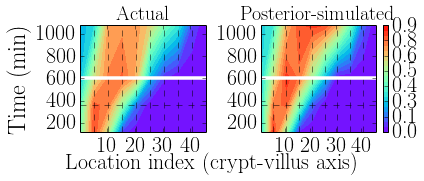

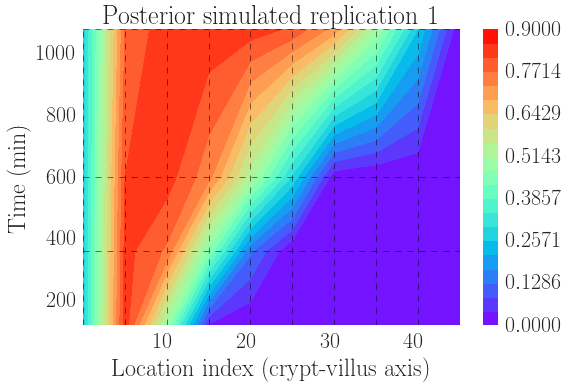

[ 0.43290008  2.23107865  2.06660255  0.62114025  0.01745145]
p non-dim
[ 0.43290008  2.23107865  2.06660255  0.62114025  0.01745145  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
num parameters: 20
p (per h)
[ 0.02705626  0.13944242  0.12916266  0.03882127  0.00109072  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
p non-dim new scale
[ 0.21645004  1.11553933  1.03330127  0.31057012  0.00872572  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]
p (per h)
[ 0.02705626  0.13944242  0.12916266  0.03882127  0.00109072  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.   

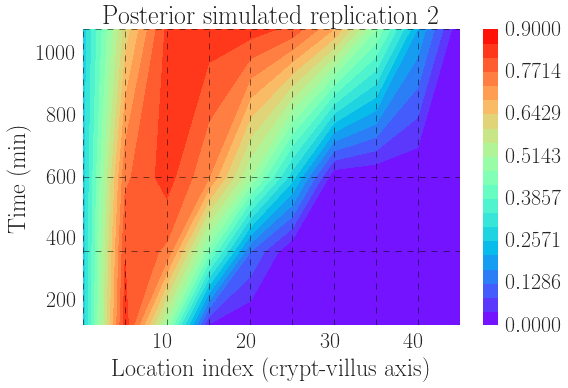

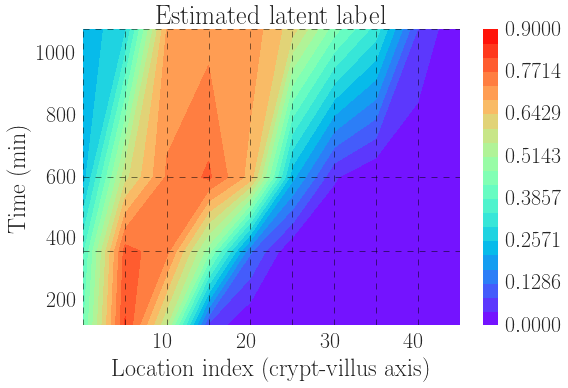

In [50]:
#--characteristic plane replications
#AraC
#data_dir='../data-working/TXT_AraC_01_IdU/'
#sample_type='AraC'
#old_out_times= np.array([1260.,1500.])#,1500.])
#actual_out_times= np.array([1260.,1500.,1620.])#,2520.]) #1080.,
t_predict= 1500.

#BrdU
#data_dir='../data-working/TXT_BrdU/'
#sample_type='BrdU'
#old_out_times= np.array([120.,360.,600.])
#actual_out_times= np.array([120.,360.,600.,1080.])
#old_out_times= np.array([120.,360.,600.])
#actual_out_times= np.array([120.,360.,600.,1080.])#,1440.,1920.,3360.])
#t_predict= 600.

precision_time=4
time_format= '%0'+('%1d' % precision_time)+'d'
time_title_format = '%0'+('%1d' % 3)+'d'
#precision_time=4
#time_format= '%0'+('%1d' % precision_time)+'d'
k=3 #spline param
s=5 #spline param

time_scale_min_old= np.max(old_out_times)-np.min(old_out_times)
time_scale_min= np.max(actual_out_times)-np.min(actual_out_times)
time_scale_sec= time_scale_min/60.0
time_scale_renorm_ratio= time_scale_min_old/time_scale_min

print 'time scales - old, new, ratio; sec'
print time_scale_min_old
print time_scale_min
print time_scale_renorm_ratio
print time_scale_sec


#-which predictive distribution (prior or posterior)
dist_type= 'posterior'
paramter_samples= np.copy(posterior_samples[0:2])
#dist_type= 'prior'
#paramter_samples= np.copy(prior_samples[0:8])

#re-scale parameter samples for different time predictions? 
paramter_samples= paramter_samples/time_scale_renorm_ratio


print len(paramter_samples)

#-plotting options
import seaborn as sns
#cmap = sns.cubehelix_palette(12, start=0.0, rot=0, dark=0.0, light=1.1, reverse=False,as_cmap=True)
cmap = mpl.cm.rainbow
x_grid_step= 5

rep_num= 0

for sample in paramter_samples:
    rep_num= rep_num+1
    print sample
    p=sample
    p= np.append(p,np.zeros(num_fixed_params))
    print 'p non-dim'
    print p
    print 'num parameters: ' + str(p.size)
    print 'p (per h)'
    p_dim = p/time_scale_sec
    print p_dim
    print 'p non-dim new scale'
    p_re_norm = p*time_scale_renorm_ratio
    print p_re_norm
    print 'p (per h)'
    print p_dim

    #run and plot CHECK: p_dim or not? Not, right?
    import time as timer
    t0 = timer.time()
    results= construct_and_run_sim(data_dir=data_dir,sample_type=sample_type,actual_out_times=actual_out_times,precision_time=4,p=p,x_min=0.,x_max=x_max,nx=100)
    l_model= results[0]
    x_model= results[2]
    tf = timer.time()
    levels= np.linspace(0,0.9,22)
    plt.figure("replication"+str(rep_num))
    contours_out= plot_contours(label_data_at_x_data=l_model[0:x_plot_max,:],x_grid_all_times=x_model[0:x_plot_max,:],actual_times=actual_out_times,sample_type=sample_type,levels=levels,data_type='P'+dist_type[1:]+' simulated replication '+str(rep_num),output_path='../figures/predictive_plots/',cmap=cmap,x_grid_step=x_grid_step,t_predict=t_predict,run_data_functions=False)
    #plt.close()

plt.figure('data')
#ax = plt.figure('data').add_subplot(111)
contours_out= plot_contours(label_data_at_x_data=label_smoothed_data_at_x_data[0:x_plot_max,:],x_grid_all_times=x_model[0:x_plot_max,:],actual_times=actual_out_times,sample_type=sample_type,levels=levels,data_type='Estimated latent label',output_path='../figures/predictive_plots/',cmap=cmap,x_grid_step=x_grid_step,t_predict=t_predict,run_data_functions=False)

    #plt.figure('data')
#fig= plt.figure('data')
#ax = plt.axes(frameon=True)
#[i.set_visible(True) for i in ax.spines.itervalues()]
#[i.set_linewidth(10.) for i in ax.spines.itervalues()]
#[i.set_color('0.0') for i in ax.spines.itervalues()]
#contours_out= plot_contours(label_data_at_x_data=label_smoothed_data_at_x_data[0:x_plot_max,:],x_grid_all_times=x_model[0:x_plot_max,:],actual_times=actual_out_times,levels=levels,data_type='estimated actual latent label',output_path='../figures/predictive_plots/',cmap=cmap,x_grid_step=x_grid_step,run_data_functions=False)
#[i.set_linewidth(0.1) for i in ax.spines.itervalues()]
    #plt.close()

#HERE.
#l_model= results[0]
#x_model= results[2]


In [71]:
plt.close('all')

In [73]:
x_model

array([[  0.5,   0.5,   0.5,   0.5],
       [  1.5,   1.5,   1.5,   1.5],
       [  2.5,   2.5,   2.5,   2.5],
       [  3.5,   3.5,   3.5,   3.5],
       [  4.5,   4.5,   4.5,   4.5],
       [  5.5,   5.5,   5.5,   5.5],
       [  6.5,   6.5,   6.5,   6.5],
       [  7.5,   7.5,   7.5,   7.5],
       [  8.5,   8.5,   8.5,   8.5],
       [  9.5,   9.5,   9.5,   9.5],
       [ 10.5,  10.5,  10.5,  10.5],
       [ 11.5,  11.5,  11.5,  11.5],
       [ 12.5,  12.5,  12.5,  12.5],
       [ 13.5,  13.5,  13.5,  13.5],
       [ 14.5,  14.5,  14.5,  14.5],
       [ 15.5,  15.5,  15.5,  15.5],
       [ 16.5,  16.5,  16.5,  16.5],
       [ 17.5,  17.5,  17.5,  17.5],
       [ 18.5,  18.5,  18.5,  18.5],
       [ 19.5,  19.5,  19.5,  19.5],
       [ 20.5,  20.5,  20.5,  20.5],
       [ 21.5,  21.5,  21.5,  21.5],
       [ 22.5,  22.5,  22.5,  22.5],
       [ 23.5,  23.5,  23.5,  23.5],
       [ 24.5,  24.5,  24.5,  24.5],
       [ 25.5,  25.5,  25.5,  25.5],
       [ 26.5,  26.5,  26.5,  26.5],
 

In [74]:
print X_model
print Y
print Z_model[:,0]
print Z_model[0,:]

[  0.5   5.5  10.5  15.5  20.5  25.5  30.5  35.5  40.5  45.5]
[  120.   360.   600.  1080.]
[ 0.2751063  0.2751063  0.2751063  0.2751063]
[  2.75106305e-01   8.41668670e-01   4.95075274e-01   3.55601660e-02
   7.67042441e-06   1.14783764e-05   1.05274162e-05   8.75186397e-06
   1.36418682e-03   1.08459821e-05]


In [83]:
plt.close('all')

In [ ]:
#save above figure


In [38]:
#FROM EXTRA FUNCS
X= x_grid_all_times[::x_grid_step,0]
Y= actual_times
Z= label_data_at_x_data[::x_grid_step].T #assume given in column format

#using custom colormap. Also using seaborn?
#import seaborn as sns
#sns.kdeplot(x, y, cmap=cmap, shade=True);

plt.contourf(X,Y,Z,levels=levels,cmap=cmap,shade=True)
#plt.imshow(X,Y,Z,interpolation='nearest')
plt.title(data_type)

plt.xlabel("Location index (crypt-villus axis)")
plt.ylabel("Time (min)")

#plt.title('Time: '+str(time_title_format%actual_out_times[i])+' min')#,size=18))
#plt.xlabel('crypt-villus axis position (cell number)')
#plt.ylabel('time (min)')
for x_loc in X:
    plt.axvline(x=x_loc,color='0.0',linestyle='--',linewidth=0.5)
    #print ''
for t_loc in Y:
    if t_loc == t_predict:
        plt.axhline(y=t_loc,color='0.0',linestyle='-',linewidth=3.0)
    else:
        plt.axhline(y=t_loc,color='0.0',linestyle='--',linewidth=0.5)
    #print ''
plt.colorbar()
plt.legend()

NameError: name 'x_grid_all_times' is not defined

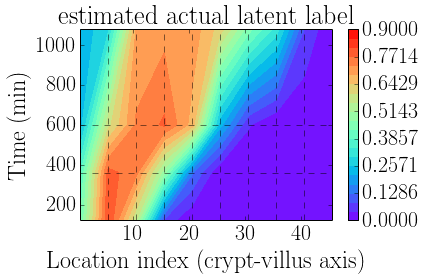

In [40]:
fig= plt.figure('data')
ax = plt.axes(frameon=True)
#[i.set_visible(True) for i in ax.spines.itervalues()]
#[i.set_linewidth(10.) for i in ax.spines.itervalues()]
#[i.set_color('0.0') for i in ax.spines.itervalues()]
contours_out= plot_contours(label_data_at_x_data=label_smoothed_data_at_x_data[0:x_plot_max,:],x_grid_all_times=x_model[0:x_plot_max,:],actual_times=actual_out_times,levels=levels,data_type='estimated actual latent label',output_path='../figures/predictive_plots/',cmap=cmap,x_grid_step=x_grid_step,run_data_functions=False)


X= x_data_to_plot[::5,0]
Y= actual_out_times
#X, Y = np.meshgrid(X, Y)
Z= label_smoothed_data_at_x_data[::5].T

from scipy.interpolate import interp2d
f_colour= interp2d(X,Y,Z,kind='linear')

X_refined= np.linspace(np.min(X),np.max(X),100)
Y_refined= np.linspace(np.min(Y),np.max(Y),2)

plt.contourf(X_refined,Y_refined,f_colour(X_refined,Y_refined),levels=levels,cmap=cmap,shade=True)
for t_loc in actual_out_times:
        plt.axhline(y=t_loc,color='0.0',linestyle='--',linewidth=0.5)
        #print ''
plt.xlim(0,x_plot_max)

(0, 50)

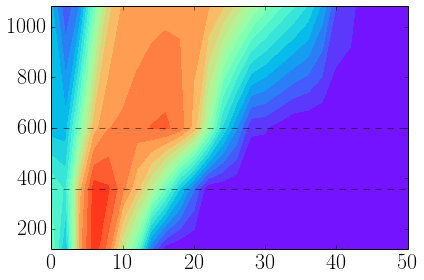

In [41]:
X= x_data_to_plot[::2,0]
Y= actual_out_times
#X, Y = np.meshgrid(X, Y)
Z= label_smoothed_data_at_x_data[::2].T

#from scipy.interpolate import interp2d
#f_colour= interp2d(X,Y,Z,kind='linear')

#X_refined= np.linspace(np.min(X),np.max(X),100)
#Y_refined= np.linspace(np.min(Y),np.max(Y),2)

plt.contourf(X,Y,Z,levels=levels,cmap=cmap,shade=True)
for t_loc in actual_out_times:
        plt.axhline(y=t_loc,color='0.0',linestyle='--',linewidth=0.5)
        #print ''
plt.xlim(0,x_plot_max)

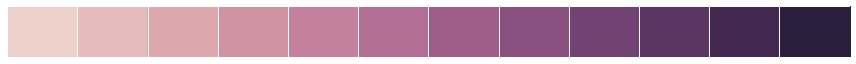

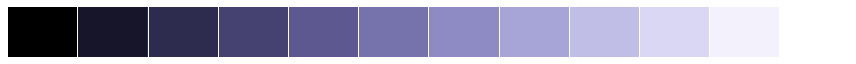

In [26]:
import seaborn as sns
#sns.kdeplot(x, y, cmap=cmap, shade=True);
sns.palplot(sns.cubehelix_palette(12))
sns.palplot(sns.cubehelix_palette(12, start=0.0, rot=0, dark=0.0, light=1.05, reverse=True))

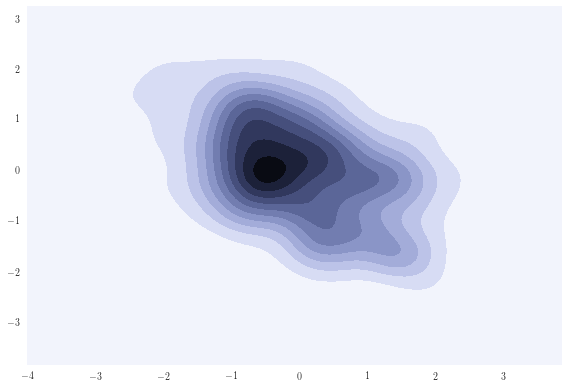

In [27]:
x, y = np.random.multivariate_normal([0, 0], [[1, -.5], [-.5, 1]], size=300).T
cmap = sns.cubehelix_palette(12, start=-0.1, rot=0, dark=0.0, light=1.0, reverse=False,as_cmap=True)
sns.kdeplot(x, y, cmap=cmap, shade=True);
#plt.contourf(x,y,y,levels=levels,cmap=cmap,shade=True)

import plotly.plotly as py
from plotly.graph_objs import *

In [28]:
plt.rcParams.update(rc_default)

#save figure
output_path='../figures/predictive_plots/'
save_path= output_path+sample_type+'/'
try:
    os.makedirs(save_path)
except OSError as exc: # Python >2.5
    if exc.errno == errno.EEXIST and os.path.isdir(save_path):
        pass
    else: raise
    plt.figure("prolif-fig")#savefig(save_path+dist_type+'proliferation-realisations-'+sample_type+'.pdf')
    #plt.savefig

### Full data replications - see above!

#--Original data
#times and format
precision_time=4
time_format= '%0'+('%1d' % precision_time)+'d'
k=3
s=5
for i in range(0,actual_out_times.size):
    current_time= actual_out_times[i]
    file_current= get_data_file(data_dir,time_format%current_time) #use ic function. might be good to change name.
    print file_current
    label_result= process_and_fit_label_data_file(data_dir=data_dir,file_to_fit=file_current,sample_type=sample_type,output_path=output_path,k=k,s=s,x_max=100,do_plot=True)
    sample_size_result= get_sample_sizes_for_data_file(data_dir=data_dir,file_to_fit=file_current,sample_type=sample_type,k=k,s=s,x_max=100,do_plot=False)
    print len(sample_size_result)
    label_mean_profile_current= label_result[0]
    label_smoothed_f_current= label_result[-1]
    #plot all splines together (individuals handled via above function)
    #plt.plot(x,label_smoothed_f_current(x),label=time_format%current_time+' min')
    print 'label'
    print label_mean_profile_current
    plt.figure("label-fig")
    plt.plot(label_mean_profile_current,'k-',label=time_format%current_time+' min'+'_raw mean',markersize=3,linewidth=2)
    plt.plot(label_smoothed_f_current(x_data_to_plot[:,0]),'k-',label=time_format%current_time+' min'+'_raw mean',markersize=3,linewidth=2,color='0.2',alpha=1.0)
print len(sample_size_result)


(-5, 5)

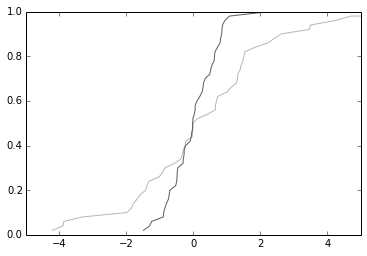

In [29]:
#import statsmodels.api as sm
#print l_data_model_resid_normed
ecdf_model = sm.distributions.ECDF(l_data_model_resid_normed)
ecdf_data = sm.distributions.ECDF(l_data_smoothed_resid_normed)
plt.figure()
plt.plot(ecdf_model.x,ecdf_model.y,color='0.6',alpha=0.7)
plt.plot(ecdf_data.x,ecdf_data.y,color='0.1',alpha=0.7)
plt.xlim(-5,5)
#plt.show()

In [30]:
#plt.figure("label-fig")

##Scratchwork

Note:  
np.random.randint  
Return random integers from the “discrete uniform” distribution in the “half-open” interval [low, high). If high is None (the default), then results are from [0, low).

In [31]:
print np.random.randint(low=0,high=2) #[0,1]
print np.random.randint(2) #[0,1]

1
1


getting covariance matrix from correlation function and standard deviations

In [32]:
kernel = kernels.ExpSquaredKernel(0.5) #0.5 -> correlation length approx. 1 parameter; 2*L.
gp = george.GP(kernel)
#sigma_prior=1./np.exp(p_var_i)# typical variation in rates. Note: should make e.g. decay? Uncertainty decreases?
correlation_matrix= gp.get_matrix(p_var_i)
sd_prior= 1.0*np.append(np.ones(len(p_var_i)-1),0.3)
var_prior= np.outer(sd_prior,sd_prior)
print var_prior
print '-'
print correlation_matrix
print '-'
print np.multiply(var_prior,correlation_matrix)
print '-'
print var_prior*correlation_matrix
#sigma= sigma_prior*gp.get_matrix(p_var_i)
#sigma[-1,-1]= np.exp(-1)*sigma[-1,-1]
#print sigma
#print sigma_prior

[[ 1.    1.    1.    1.    0.3 ]
 [ 1.    1.    1.    1.    0.3 ]
 [ 1.    1.    1.    1.    0.3 ]
 [ 1.    1.    1.    1.    0.3 ]
 [ 0.3   0.3   0.3   0.3   0.09]]
-
[[  1.00000000e+00   3.67879441e-01   1.83156389e-02   1.23409804e-04
    1.12535175e-07]
 [  3.67879441e-01   1.00000000e+00   3.67879441e-01   1.83156389e-02
    1.23409804e-04]
 [  1.83156389e-02   3.67879441e-01   1.00000000e+00   3.67879441e-01
    1.83156389e-02]
 [  1.23409804e-04   1.83156389e-02   3.67879441e-01   1.00000000e+00
    3.67879441e-01]
 [  1.12535175e-07   1.23409804e-04   1.83156389e-02   3.67879441e-01
    1.00000000e+00]]
-
[[  1.00000000e+00   3.67879441e-01   1.83156389e-02   1.23409804e-04
    3.37605524e-08]
 [  3.67879441e-01   1.00000000e+00   3.67879441e-01   1.83156389e-02
    3.70229412e-05]
 [  1.83156389e-02   3.67879441e-01   1.00000000e+00   3.67879441e-01
    5.49469167e-03]
 [  1.23409804e-04   1.83156389e-02   3.67879441e-01   1.00000000e+00
    1.10363832e-01]
 [  3.37605524e-08 

In [33]:
#changing plotting options 'globally' (then re-setting)
#from: http://nbviewer.ipython.org/github/swcarpentry/2012-11-scripps/blob/master/python/matplotlib-full.ipynb

# Choose a bunch of new parameter values
# In practice, you'll try modifying these, running the code and saving the figure,
# looking at the figure, then making more modifications until you're happy.
newparams = {'axes.labelsize': 14, 'axes.linewidth': 1, 'savefig.dpi': 300, 
             'lines.linewidth': 1.5, 'figure.figsize': (8, 3),
             'figure.subplot.wspace': 0.4,
             'ytick.labelsize': 12, 'xtick.labelsize': 12,
             'ytick.major.pad': 5, 'xtick.major.pad': 5,
             'legend.fontsize': 12, 'legend.frameon': False, 
             'legend.handlelength': 1.5}

# Update the global rcParams dictionary with the new parameter choices
# Before doing this, we reset rcParams to its default again, just in case
plt.rcParams.update(rcdef)
plt.rcParams.update(newparams)

# Make the new figure with new formatting
fig, axall = plt.subplots(1, 2)

for ax in axall:
    ax.plot(np.random.rand(100), 'k-o', label='Random')
    ax.set_ylim([0, 1.2])
    ax.set_ylabel('Value')
    ax.legend()
    
fig.savefig('myfig-advanced.png')

# Put rcParams back to default
plt.rcParams.update(rcdef)

NameError: name 'rcdef' is not defined

In [34]:
# View rcParams
plt.rcParams

RcParams({'agg.path.chunksize': 0,
          'animation.avconv_args': '',
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'mpeg4',
          'animation.convert_args': '',
          'animation.convert_path': 'convert',
          'animation.ffmpeg_args': '',
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.mencoder_args': '',
          'animation.mencoder_path': 'mencoder',
          'animation.writer': 'ffmpeg',
          'axes.axisbelow': False,
          'axes.color_cycle': ['b', 'g', 'r', 'c', 'm', 'y', 'k'],
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.grid': False,
          'axes.hold': True,
          'axes.labelcolor': 'k',
          'axes.labelsize': 'medium',
          'axes.labelweight

In [35]:
np.max(actual_out_times)-np.min(actual_out_times)

1260.0

In [36]:
#k=kbar*(1/Ts/60) = kbar*(1/Ts)*(60)

[24 44  0  0  1]
[ 0.6   0.88   nan   nan  0.2 ]


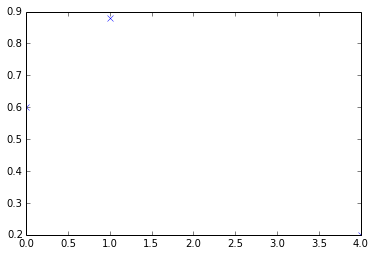

In [37]:
a= np.array([40.0,50,0.0,0.0,5.0])
b= np.array([0.5,0.9,1.0,0.0,0.5])

c= np.random.binomial(a.astype(int).T,b.T)
print c
d= np.divide(c,a)
print d
plt.plot(d,'x')

[[25 50  0  0  4  2  2  1  9]
 [20 47  0  0  2  7  1  4 10]
 [13 46  0  0  1  2  2  1  8]
 [23 43  0  0  3  2  0  3 12]
 [20 44  0  0  5  0  1  3 12]
 [21 45  0  0  1  4  1  5 13]
 [23 46  0  0  2  4  1  4  8]
 [23 46  0  0  2  6  0  1  9]
 [15 46  0  0  3  4  2  6 11]
 [17 47  0  0  2  5  1  3 10]
 [16 45  0  0  2  3  3  6 12]
 [19 41  0  0  3  2  2  2  9]
 [19 45  0  0  2  2  1  6 12]
 [17 44  0  0  2  0  1  4  9]
 [26 47  0  0  1  4  2  2 10]
 [15 47  0  0  1  3  0  4 12]
 [23 40  0  0  2  5  1  2  9]
 [18 50  0  0  1  2  0  3  9]]
here
[[25 50  0]
 [20 47  0]
 [13 46  0]
 [23 43  0]
 [20 44  0]
 [21 45  0]
 [23 46  0]
 [23 46  0]
 [15 46  0]
 [17 47  0]
 [16 45  0]
 [19 41  0]
 [19 45  0]
 [17 44  0]
 [26 47  0]
 [15 47  0]
 [23 40  0]
 [18 50  0]]
[[ 0.625       0.5         0.325       0.575       0.5         0.525       0.575
   0.575       0.375       0.425       0.4         0.475       0.475       0.425
   0.65        0.375       0.575       0.45      ]
 [ 1.          0.94     

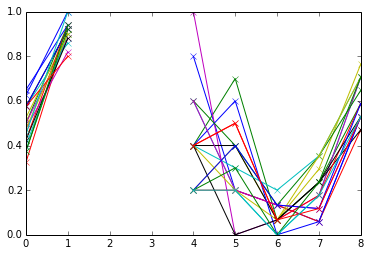

In [38]:
a= np.array([40.0,50,0.0,0.0,5.0,10,15,17,17])
b= np.array([0.5,0.9,1.0,0.0,0.5,0.3,0.1,0.2,0.6])
#c= np.random.binomial()
c= np.random.binomial(a.astype(int),b,size=[2*len(a),len(a)])
print c
print 'here'
print c[:,0:3]
d= np.divide(c,a)
print d.T
plt.plot(np.arange(0,len(a)),d.T,'-x')


In [40]:
'P'+dist_type[1:]

'Posterior'

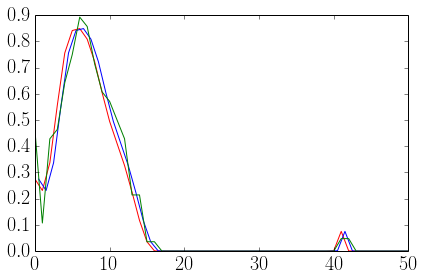

In [29]:
plt.figure("testnew")
plt.plot(x_model[:,0]-0.5,l_model[:,0],'r')
plt.plot(x_model[:,0],l_model[:,0])
plt.plot(x_data_to_plot[:,0],label_data_at_x_data[:,0])
plt.xlim(0,50)
plt.figure("testnew").show()

        #doesn't work?
        #re-arrange figures
        for fig_name in plt.get_figlabels(): 
            print(fig_name)

        # From - http://matplotlib.org/1.2.1/api/backend_pdf_api.html
        from matplotlib.backends.backend_pdf import PdfPages
        # Initialize:
        pp = PdfPages(save_path+dist_type+'-multi-'+sample_type+'.pdf')

        # As many times as you like, create a figure fig, then either:
        plt.figure("vel-fig-"+dist_type).savefig(pp, format='pdf') # note the format argument!
        plt.figure("prolif-fig-"+dist_type).savefig(pp, format='pdf') # note the format argument!

        # or:
        #plt.figure("vel-fig-"+dist_type).show()
        #plt.figure("prolif-fig-"+dist_type).show()
        #pp.savefig("vel-fig-"+dist_type)
        #pp.savefig("prolif-fig-"+dist_type)

        # Once you are done, remember to close the object:
        pp.close()
        #plt.figure("vel-fig-"+dist_type).show()
        #temp = plt.figure("vel-fig-"+dist_type)
        #plt.figure("new-test")
        #plt.subplot(1,1,1)
        #plt.figure("vel-fig-"+dist_type)
        #ax = plt.gca()
        #plt.figure("test")

        #plt.axhline(y=0.1,color='0.0',linestyle='--',linewidth=1.2)
        #vertical scale bar param
        #plt.figure("prolif-fig-"+dist_type).show()
        #plt.figure("label-fig-"+str(actual_out_times[1])).show()
        #plt.figure("label-rep-fig-"+str(actual_out_times[1])).show()

        #save figure
        #output_path='../figures/predictive_plots/'
        #save_path= output_path+sample_type+'/'

        #pp.savefig(save_path+dist_type+'-multi-'+sample_type+'.pdf')
        #pp.close()